In [1]:
!pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0 \
 --extra-index-url https://download.pytorch.org/whl/cu121

Defaulting to user installation because normal site-packages is not writeable


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121


In [2]:
!pip uninstall numpy -y
!pip install numpy==1.26.4


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.4 which is incompatible.


In [3]:
!pip install \
    torch-scatter \
    torch-sparse \
    torch-cluster \
    torch-spline-conv \
    -f https://data.pyg.org/whl/torch-2.1.0+cu121.html


Defaulting to user installation because normal site-packages is not writeable


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


In [4]:
!pip install torch-geometric

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.1.0+cu121
12.1


In [6]:
!pip install open3d torch-cluster


Defaulting to user installation because normal site-packages is not writeable


In [7]:
!pip install rtree

Defaulting to user installation because normal site-packages is not writeable


In [8]:
# CELL 1
import os
import numpy as np
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import trimesh

DATA_DIR = '/home/exouser/02_triangular_mesh_autoencoder/Dataset/meshes_mcubes'
PRECOMP_DIR = '/home/exouser/02_triangular_mesh_autoencoder/Dataset/precomputed_sdf_4096'
os.makedirs(PRECOMP_DIR, exist_ok=True)

NUM_POINTS = 4096
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LATENT_DIM = 256
BATCH_SIZE = 8
LR = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 1000
CHECKPOINT_DIR = '/home/exouser/02_triangular_mesh_autoencoder/checkpoints/mesh_autodecoder'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

DELTA = 0.1
MAX_CHUNK = 8192
LATENT_REG_WEIGHT = 1e-4
NUM_WORKERS = 4


# Implicit SDF data generation

In [9]:
# CELL 2 — UPDATED SIGNED SDF CONVERSION

def normalize_vertices(v):
    c = v.mean(axis=0, keepdims=True)
    v = v - c
    s = np.max(np.linalg.norm(v, axis=1))
    return v / (s + 1e-9)


def compute_signed_distance(mesh: trimesh.Trimesh, pts: np.ndarray):
    """
    Compute true signed distance for each point:
    SDF(x) = dist(x, surface)   if outside
           = -dist(x, surface)  if inside
    """
    # Closest points (fast)
    closest_points, _, _ = mesh.nearest.on_surface(pts)
    dist = np.linalg.norm(pts - closest_points, axis=1)

    # inside/outside test
    try:
        inside = mesh.contains(pts)
    except Exception:
        inside = np.zeros(len(pts), dtype=bool)
        CH = 50000
        for i in range(0, len(pts), CH):
            inside[i:i+CH] = mesh.contains(pts[i:i+CH])

    sdf = dist
    sdf[inside] *= -1.0
    return sdf.astype(np.float32)


def sample_sdf_points_from_mesh(mesh, n_samples=4096):
    """
    Create hybrid sampling:
      • 50% near-surface jittered samples
      • 50% random uniform bbox samples
    """
    n_surface = n_samples // 2
    n_rand = n_samples - n_surface

    # Surface samples
    surface_samples, _ = trimesh.sample.sample_surface(mesh, n_surface)
    jitter = np.random.normal(scale=0.01, size=surface_samples.shape).astype(np.float32)
    near_pts = surface_samples.astype(np.float32) + jitter

    # Uniform bbox samples
    low = mesh.bounds[0] - 0.1
    high = mesh.bounds[1] + 0.1
    rand_pts = np.random.uniform(low, high, size=(n_rand, 3)).astype(np.float32)

    pts = np.vstack([near_pts, rand_pts])
    sdf = compute_signed_distance(mesh, pts)
    return pts.astype(np.float32), sdf.astype(np.float32)


# Precompute SDF for full dataset
mesh_paths = sorted(glob(os.path.join(DATA_DIR, "*.ply")))
if len(mesh_paths) == 0:
    raise RuntimeError(f"No .ply files found in {DATA_DIR}")

print(f"Found {len(mesh_paths)} meshes. Saving SDF samples to: {PRECOMP_DIR}")

for path in tqdm(mesh_paths, desc="Precomputing SDF"):
    base = os.path.basename(path)
    name = os.path.splitext(base)[0]
    out_path = os.path.join(PRECOMP_DIR, f"{name}.npz")

    if os.path.exists(out_path):
        continue

    try:
        mesh = trimesh.load(path, process=False)

        if not isinstance(mesh, trimesh.Trimesh):
            mesh = trimesh.util.concatenate(mesh.dump())

        # normalize to unit sphere
        verts = np.array(mesh.vertices, dtype=np.float64)
        verts = normalize_vertices(verts)
        mesh = trimesh.Trimesh(vertices=verts, faces=np.array(mesh.faces), process=False)

        pts, sdf = sample_sdf_points_from_mesh(mesh, NUM_POINTS)
        np.savez_compressed(out_path, pts=pts, sdf=sdf)

    except Exception as e:
        print(f"Failed: {path}  |  Error: {e}")


Found 1045 meshes. Saving SDF samples to: /home/exouser/02_triangular_mesh_autoencoder/Dataset/precomputed_sdf_4096


Precomputing SDF:  50%|████▉     | 522/1045 [00:05<00:05, 87.44it/s]


KeyboardInterrupt: 

In [ ]:
import numpy as np
import trimesh
import os

def npz_to_ply(npz_path, ply_out_path, thresh=0.002):
    data = np.load(npz_path)
    pts = data["pts"]         # (N,3)
    sdf = data["sdf"]         # (N,)

    # Normalize sdf for visualization
    inside = sdf < -thresh
    outside = sdf > thresh
    surface = (~inside) & (~outside)

    colors = np.zeros((pts.shape[0], 3), dtype=np.uint8)

    # inside = green
    colors[inside] = np.array([0, 255, 0], dtype=np.uint8)
    # outside = red
    colors[outside] = np.array([255, 0, 0], dtype=np.uint8)
    # near surface = white
    colors[surface] = np.array([255, 255, 255], dtype=np.uint8)

    # Create PLY point cloud
    cloud = trimesh.PointCloud(pts, colors=colors)

    # Save PLY
    cloud.export(ply_out_path)
    print(f"Saved: {ply_out_path}")


# Example usage:
npz_to_ply("/home/exouser/02_triangular_mesh_autoencoder/Dataset/precomputed_sdf_4096/0002.npz", "mesh_0001.ply")


In [9]:
# CELL 3
class PrecompSDFDataset(Dataset):
    def __init__(self, precomp_dir):
        self.files = sorted(glob(os.path.join(precomp_dir, "*.npz")))
        assert len(self.files) > 0, f"No precomputed .npz files in {precomp_dir}"

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        pts = torch.from_numpy(data["pts"]).float()
        sdf = torch.from_numpy(data["sdf"]).float()
        return pts, sdf, idx


In [10]:
# CELL 4
class DeepSDFDecoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim + 3, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512 + latent_dim + 3, 512)  # skip
        self.fc5 = nn.Linear(512, 512)
        self.fc6 = nn.Linear(512, 512)
        self.fc7 = nn.Linear(512, 512)
        self.fc8 = nn.Linear(512, 1)

    def forward(self, z, x):
        inp = torch.cat([z, x], dim=-1)
        h = F.relu(self.fc1(inp))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = torch.cat([h, inp], dim=-1)
        h = F.relu(self.fc4(h))
        h = F.relu(self.fc5(h))
        h = F.relu(self.fc6(h))
        h = F.relu(self.fc7(h))
        out = torch.tanh(self.fc8(h))
        return out


def init_latent_codes(num_shapes, latent_dim=LATENT_DIM, std=0.01):
    emb = nn.Embedding(num_shapes, latent_dim)
    nn.init.normal_(emb.weight, 0.0, std)
    return emb


In [11]:
# CELL 5
dataset = PrecompSDFDataset(PRECOMP_DIR)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
                        num_workers=NUM_WORKERS, pin_memory=True)

decoder = DeepSDFDecoder().to(DEVICE)
latent_codes = init_latent_codes(len(dataset)).to(DEVICE)

optimizer = torch.optim.Adam(
    list(decoder.parameters()) + list(latent_codes.parameters()),
    lr=LR, weight_decay=WEIGHT_DECAY,
)

def clamp_tensor(t, delta=DELTA):
    return torch.clamp(t, -delta, delta)

for epoch in range(EPOCHS):
    total_loss = 0.0
    count = 0

    for pts, sdf, idxs in tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        B, N, _ = pts.shape
        pts = pts.to(DEVICE)
        sdf = sdf.to(DEVICE).unsqueeze(-1)
        idxs = idxs.to(DEVICE)

        z = latent_codes(idxs)
        z_expanded = z.unsqueeze(1).expand(-1, N, -1).reshape(-1, LATENT_DIM)
        pts_flat = pts.reshape(-1, 3)
        sdf_flat = sdf.reshape(-1, 1)

        optimizer.zero_grad()

        # chunked to avoid OOM
        M = pts_flat.shape[0]
        loss_sum = 0.0

        for s in range(0, M, MAX_CHUNK):
            e = min(s + MAX_CHUNK, M)
            pred = decoder(z_expanded[s:e], pts_flat[s:e])
            l = torch.abs(clamp_tensor(pred) - clamp_tensor(sdf_flat[s:e])).mean()
            loss_sum += l * (e - s)

        recon_loss = loss_sum / M

        latent_reg = (z.pow(2).sum(dim=1).mean()) * LATENT_REG_WEIGHT
        loss = recon_loss + latent_reg

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * B
        count += B

    avg = total_loss / count
    print(f"Epoch {epoch+1} | Loss = {avg:.6f}")

    torch.save({
        "epoch": epoch+1,
        "decoder": decoder.state_dict(),
        "latent": latent_codes.state_dict()
    }, os.path.join(CHECKPOINT_DIR, f"epoch_{epoch+1}.pth"))


Epoch 1/1000: 100%|██████████| 66/66 [00:02<00:00, 26.37it/s]


Epoch 1 | Loss = 0.029938


Epoch 2/1000: 100%|██████████| 66/66 [00:01<00:00, 34.43it/s]


Epoch 2 | Loss = 0.018518


Epoch 3/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 3 | Loss = 0.016877


Epoch 4/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 4 | Loss = 0.017423


Epoch 5/1000: 100%|██████████| 66/66 [00:01<00:00, 34.82it/s]


Epoch 5 | Loss = 0.015439


Epoch 6/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 6 | Loss = 0.014982


Epoch 7/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 7 | Loss = 0.014304


Epoch 8/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 8 | Loss = 0.014610


Epoch 9/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 9 | Loss = 0.013848


Epoch 10/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 10 | Loss = 0.013498


Epoch 11/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 11 | Loss = 0.013382


Epoch 12/1000: 100%|██████████| 66/66 [00:01<00:00, 34.87it/s]


Epoch 12 | Loss = 0.013259


Epoch 13/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 13 | Loss = 0.013073


Epoch 14/1000: 100%|██████████| 66/66 [00:01<00:00, 34.79it/s]


Epoch 14 | Loss = 0.013076


Epoch 15/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 15 | Loss = 0.012864


Epoch 16/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 16 | Loss = 0.012711


Epoch 17/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 17 | Loss = 0.012560


Epoch 18/1000: 100%|██████████| 66/66 [00:01<00:00, 34.42it/s]


Epoch 18 | Loss = 0.012538


Epoch 19/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 19 | Loss = 0.012474


Epoch 20/1000: 100%|██████████| 66/66 [00:01<00:00, 34.43it/s]


Epoch 20 | Loss = 0.012411


Epoch 21/1000: 100%|██████████| 66/66 [00:01<00:00, 34.28it/s]


Epoch 21 | Loss = 0.012206


Epoch 22/1000: 100%|██████████| 66/66 [00:01<00:00, 34.36it/s]


Epoch 22 | Loss = 0.012096


Epoch 23/1000: 100%|██████████| 66/66 [00:01<00:00, 34.45it/s]


Epoch 23 | Loss = 0.012028


Epoch 24/1000: 100%|██████████| 66/66 [00:01<00:00, 34.27it/s]


Epoch 24 | Loss = 0.012048


Epoch 25/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 25 | Loss = 0.011931


Epoch 26/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 26 | Loss = 0.012006


Epoch 27/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 27 | Loss = 0.011953


Epoch 28/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 28 | Loss = 0.011770


Epoch 29/1000: 100%|██████████| 66/66 [00:01<00:00, 34.48it/s]


Epoch 29 | Loss = 0.011652


Epoch 30/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 30 | Loss = 0.011469


Epoch 31/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 31 | Loss = 0.011567


Epoch 32/1000: 100%|██████████| 66/66 [00:01<00:00, 34.49it/s]


Epoch 32 | Loss = 0.011781


Epoch 33/1000: 100%|██████████| 66/66 [00:01<00:00, 34.16it/s]


Epoch 33 | Loss = 0.011439


Epoch 34/1000: 100%|██████████| 66/66 [00:01<00:00, 34.31it/s]


Epoch 34 | Loss = 0.011368


Epoch 35/1000: 100%|██████████| 66/66 [00:01<00:00, 34.38it/s]


Epoch 35 | Loss = 0.011492


Epoch 36/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 36 | Loss = 0.011452


Epoch 37/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 37 | Loss = 0.011359


Epoch 38/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 38 | Loss = 0.011251


Epoch 39/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 39 | Loss = 0.011320


Epoch 40/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 40 | Loss = 0.011172


Epoch 41/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 41 | Loss = 0.011118


Epoch 42/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 42 | Loss = 0.010894


Epoch 43/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 43 | Loss = 0.010809


Epoch 44/1000: 100%|██████████| 66/66 [00:01<00:00, 35.00it/s]


Epoch 44 | Loss = 0.010874


Epoch 45/1000: 100%|██████████| 66/66 [00:01<00:00, 34.93it/s]


Epoch 45 | Loss = 0.010906


Epoch 46/1000: 100%|██████████| 66/66 [00:01<00:00, 34.52it/s]


Epoch 46 | Loss = 0.010725


Epoch 47/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 47 | Loss = 0.010712


Epoch 48/1000: 100%|██████████| 66/66 [00:01<00:00, 34.48it/s]


Epoch 48 | Loss = 0.011038


Epoch 49/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 49 | Loss = 0.010873


Epoch 50/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 50 | Loss = 0.010799


Epoch 51/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 51 | Loss = 0.010665


Epoch 52/1000: 100%|██████████| 66/66 [00:01<00:00, 34.86it/s]


Epoch 52 | Loss = 0.010640


Epoch 53/1000: 100%|██████████| 66/66 [00:01<00:00, 34.79it/s]


Epoch 53 | Loss = 0.010628


Epoch 54/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 54 | Loss = 0.010522


Epoch 55/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 55 | Loss = 0.010651


Epoch 56/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 56 | Loss = 0.010506


Epoch 57/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 57 | Loss = 0.010424


Epoch 58/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 58 | Loss = 0.010382


Epoch 59/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 59 | Loss = 0.010281


Epoch 60/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 60 | Loss = 0.010492


Epoch 61/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 61 | Loss = 0.010554


Epoch 62/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 62 | Loss = 0.010431


Epoch 63/1000: 100%|██████████| 66/66 [00:01<00:00, 34.81it/s]


Epoch 63 | Loss = 0.010375


Epoch 64/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 64 | Loss = 0.010224


Epoch 65/1000: 100%|██████████| 66/66 [00:01<00:00, 34.78it/s]


Epoch 65 | Loss = 0.010167


Epoch 66/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 66 | Loss = 0.010272


Epoch 67/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 67 | Loss = 0.010323


Epoch 68/1000: 100%|██████████| 66/66 [00:01<00:00, 34.82it/s]


Epoch 68 | Loss = 0.010248


Epoch 69/1000: 100%|██████████| 66/66 [00:01<00:00, 34.85it/s]


Epoch 69 | Loss = 0.010204


Epoch 70/1000: 100%|██████████| 66/66 [00:01<00:00, 34.98it/s]


Epoch 70 | Loss = 0.010112


Epoch 71/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 71 | Loss = 0.010012


Epoch 72/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 72 | Loss = 0.009977


Epoch 73/1000: 100%|██████████| 66/66 [00:01<00:00, 34.92it/s]


Epoch 73 | Loss = 0.010129


Epoch 74/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 74 | Loss = 0.010103


Epoch 75/1000: 100%|██████████| 66/66 [00:01<00:00, 34.20it/s]


Epoch 75 | Loss = 0.009954


Epoch 76/1000: 100%|██████████| 66/66 [00:01<00:00, 34.26it/s]


Epoch 76 | Loss = 0.009980


Epoch 77/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 77 | Loss = 0.010070


Epoch 78/1000: 100%|██████████| 66/66 [00:01<00:00, 34.21it/s]


Epoch 78 | Loss = 0.009941


Epoch 79/1000: 100%|██████████| 66/66 [00:01<00:00, 33.38it/s]


Epoch 79 | Loss = 0.009893


Epoch 80/1000: 100%|██████████| 66/66 [00:01<00:00, 33.09it/s]


Epoch 80 | Loss = 0.009915


Epoch 81/1000: 100%|██████████| 66/66 [00:01<00:00, 33.06it/s]


Epoch 81 | Loss = 0.010031


Epoch 82/1000: 100%|██████████| 66/66 [00:01<00:00, 33.46it/s]


Epoch 82 | Loss = 0.009951


Epoch 83/1000: 100%|██████████| 66/66 [00:01<00:00, 33.70it/s]


Epoch 83 | Loss = 0.010085


Epoch 84/1000: 100%|██████████| 66/66 [00:01<00:00, 33.01it/s]


Epoch 84 | Loss = 0.009968


Epoch 85/1000: 100%|██████████| 66/66 [00:01<00:00, 33.66it/s]


Epoch 85 | Loss = 0.009832


Epoch 86/1000: 100%|██████████| 66/66 [00:01<00:00, 33.65it/s]


Epoch 86 | Loss = 0.009726


Epoch 87/1000: 100%|██████████| 66/66 [00:01<00:00, 33.89it/s]


Epoch 87 | Loss = 0.009724


Epoch 88/1000: 100%|██████████| 66/66 [00:01<00:00, 33.94it/s]


Epoch 88 | Loss = 0.009703


Epoch 89/1000: 100%|██████████| 66/66 [00:01<00:00, 33.71it/s]


Epoch 89 | Loss = 0.009895


Epoch 90/1000: 100%|██████████| 66/66 [00:01<00:00, 33.97it/s]


Epoch 90 | Loss = 0.009807


Epoch 91/1000: 100%|██████████| 66/66 [00:01<00:00, 34.18it/s]


Epoch 91 | Loss = 0.009909


Epoch 92/1000: 100%|██████████| 66/66 [00:01<00:00, 33.97it/s]


Epoch 92 | Loss = 0.009813


Epoch 93/1000: 100%|██████████| 66/66 [00:01<00:00, 33.23it/s]


Epoch 93 | Loss = 0.009775


Epoch 94/1000: 100%|██████████| 66/66 [00:01<00:00, 33.81it/s]


Epoch 94 | Loss = 0.009812


Epoch 95/1000: 100%|██████████| 66/66 [00:01<00:00, 34.45it/s]


Epoch 95 | Loss = 0.009774


Epoch 96/1000: 100%|██████████| 66/66 [00:01<00:00, 34.44it/s]


Epoch 96 | Loss = 0.009713


Epoch 97/1000: 100%|██████████| 66/66 [00:01<00:00, 34.40it/s]


Epoch 97 | Loss = 0.009654


Epoch 98/1000: 100%|██████████| 66/66 [00:01<00:00, 33.63it/s]


Epoch 98 | Loss = 0.009860


Epoch 99/1000: 100%|██████████| 66/66 [00:01<00:00, 33.82it/s]


Epoch 99 | Loss = 0.009709


Epoch 100/1000: 100%|██████████| 66/66 [00:01<00:00, 33.89it/s]


Epoch 100 | Loss = 0.009774


Epoch 101/1000: 100%|██████████| 66/66 [00:01<00:00, 33.70it/s]


Epoch 101 | Loss = 0.009697


Epoch 102/1000: 100%|██████████| 66/66 [00:01<00:00, 34.02it/s]


Epoch 102 | Loss = 0.009623


Epoch 103/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 103 | Loss = 0.009603


Epoch 104/1000: 100%|██████████| 66/66 [00:01<00:00, 33.44it/s]


Epoch 104 | Loss = 0.009484


Epoch 105/1000: 100%|██████████| 66/66 [00:01<00:00, 33.68it/s]


Epoch 105 | Loss = 0.009515


Epoch 106/1000: 100%|██████████| 66/66 [00:01<00:00, 33.89it/s]


Epoch 106 | Loss = 0.009583


Epoch 107/1000: 100%|██████████| 66/66 [00:01<00:00, 34.19it/s]


Epoch 107 | Loss = 0.009520


Epoch 108/1000: 100%|██████████| 66/66 [00:01<00:00, 34.35it/s]


Epoch 108 | Loss = 0.009579


Epoch 109/1000: 100%|██████████| 66/66 [00:01<00:00, 34.12it/s]


Epoch 109 | Loss = 0.009507


Epoch 110/1000: 100%|██████████| 66/66 [00:01<00:00, 34.14it/s]


Epoch 110 | Loss = 0.009465


Epoch 111/1000: 100%|██████████| 66/66 [00:01<00:00, 34.03it/s]


Epoch 111 | Loss = 0.009374


Epoch 112/1000: 100%|██████████| 66/66 [00:01<00:00, 33.71it/s]


Epoch 112 | Loss = 0.009471


Epoch 113/1000: 100%|██████████| 66/66 [00:01<00:00, 34.14it/s]


Epoch 113 | Loss = 0.009526


Epoch 114/1000: 100%|██████████| 66/66 [00:01<00:00, 34.43it/s]


Epoch 114 | Loss = 0.009499


Epoch 115/1000: 100%|██████████| 66/66 [00:01<00:00, 34.34it/s]


Epoch 115 | Loss = 0.009775


Epoch 116/1000: 100%|██████████| 66/66 [00:01<00:00, 33.91it/s]


Epoch 116 | Loss = 0.009581


Epoch 117/1000: 100%|██████████| 66/66 [00:01<00:00, 34.22it/s]


Epoch 117 | Loss = 0.009965


Epoch 118/1000: 100%|██████████| 66/66 [00:01<00:00, 33.79it/s]


Epoch 118 | Loss = 0.009823


Epoch 119/1000: 100%|██████████| 66/66 [00:01<00:00, 34.02it/s]


Epoch 119 | Loss = 0.009706


Epoch 120/1000: 100%|██████████| 66/66 [00:01<00:00, 34.29it/s]


Epoch 120 | Loss = 0.009525


Epoch 121/1000: 100%|██████████| 66/66 [00:01<00:00, 33.68it/s]


Epoch 121 | Loss = 0.009420


Epoch 122/1000: 100%|██████████| 66/66 [00:01<00:00, 34.32it/s]


Epoch 122 | Loss = 0.009353


Epoch 123/1000: 100%|██████████| 66/66 [00:01<00:00, 33.98it/s]


Epoch 123 | Loss = 0.009373


Epoch 124/1000: 100%|██████████| 66/66 [00:01<00:00, 33.76it/s]


Epoch 124 | Loss = 0.009428


Epoch 125/1000: 100%|██████████| 66/66 [00:01<00:00, 33.66it/s]


Epoch 125 | Loss = 0.009325


Epoch 126/1000: 100%|██████████| 66/66 [00:01<00:00, 34.03it/s]


Epoch 126 | Loss = 0.009359


Epoch 127/1000: 100%|██████████| 66/66 [00:01<00:00, 34.41it/s]


Epoch 127 | Loss = 0.009420


Epoch 128/1000: 100%|██████████| 66/66 [00:01<00:00, 34.26it/s]


Epoch 128 | Loss = 0.009524


Epoch 129/1000: 100%|██████████| 66/66 [00:01<00:00, 34.03it/s]


Epoch 129 | Loss = 0.009341


Epoch 130/1000: 100%|██████████| 66/66 [00:01<00:00, 33.98it/s]


Epoch 130 | Loss = 0.009210


Epoch 131/1000: 100%|██████████| 66/66 [00:01<00:00, 34.20it/s]


Epoch 131 | Loss = 0.009122


Epoch 132/1000: 100%|██████████| 66/66 [00:01<00:00, 34.12it/s]


Epoch 132 | Loss = 0.009208


Epoch 133/1000: 100%|██████████| 66/66 [00:01<00:00, 33.82it/s]


Epoch 133 | Loss = 0.009432


Epoch 134/1000: 100%|██████████| 66/66 [00:01<00:00, 34.21it/s]


Epoch 134 | Loss = 0.009381


Epoch 135/1000: 100%|██████████| 66/66 [00:01<00:00, 34.13it/s]


Epoch 135 | Loss = 0.009379


Epoch 136/1000: 100%|██████████| 66/66 [00:01<00:00, 33.69it/s]


Epoch 136 | Loss = 0.009315


Epoch 137/1000: 100%|██████████| 66/66 [00:01<00:00, 34.02it/s]


Epoch 137 | Loss = 0.009260


Epoch 138/1000: 100%|██████████| 66/66 [00:01<00:00, 34.21it/s]


Epoch 138 | Loss = 0.009251


Epoch 139/1000: 100%|██████████| 66/66 [00:01<00:00, 34.18it/s]


Epoch 139 | Loss = 0.009270


Epoch 140/1000: 100%|██████████| 66/66 [00:01<00:00, 34.00it/s]


Epoch 140 | Loss = 0.009459


Epoch 141/1000: 100%|██████████| 66/66 [00:01<00:00, 34.22it/s]


Epoch 141 | Loss = 0.009464


Epoch 142/1000: 100%|██████████| 66/66 [00:01<00:00, 33.63it/s]


Epoch 142 | Loss = 0.009536


Epoch 143/1000: 100%|██████████| 66/66 [00:01<00:00, 33.82it/s]


Epoch 143 | Loss = 0.009387


Epoch 144/1000: 100%|██████████| 66/66 [00:01<00:00, 33.30it/s]


Epoch 144 | Loss = 0.009222


Epoch 145/1000: 100%|██████████| 66/66 [00:01<00:00, 33.69it/s]


Epoch 145 | Loss = 0.009144


Epoch 146/1000: 100%|██████████| 66/66 [00:01<00:00, 33.77it/s]


Epoch 146 | Loss = 0.009090


Epoch 147/1000: 100%|██████████| 66/66 [00:01<00:00, 33.90it/s]


Epoch 147 | Loss = 0.009201


Epoch 148/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 148 | Loss = 0.009209


Epoch 149/1000: 100%|██████████| 66/66 [00:01<00:00, 34.25it/s]


Epoch 149 | Loss = 0.009240


Epoch 150/1000: 100%|██████████| 66/66 [00:01<00:00, 33.79it/s]


Epoch 150 | Loss = 0.009228


Epoch 151/1000: 100%|██████████| 66/66 [00:01<00:00, 33.41it/s]


Epoch 151 | Loss = 0.009127


Epoch 152/1000: 100%|██████████| 66/66 [00:01<00:00, 33.52it/s]


Epoch 152 | Loss = 0.009121


Epoch 153/1000: 100%|██████████| 66/66 [00:01<00:00, 34.26it/s]


Epoch 153 | Loss = 0.009205


Epoch 154/1000: 100%|██████████| 66/66 [00:01<00:00, 34.11it/s]


Epoch 154 | Loss = 0.009290


Epoch 155/1000: 100%|██████████| 66/66 [00:01<00:00, 33.81it/s]


Epoch 155 | Loss = 0.009219


Epoch 156/1000: 100%|██████████| 66/66 [00:01<00:00, 34.26it/s]


Epoch 156 | Loss = 0.009289


Epoch 157/1000: 100%|██████████| 66/66 [00:01<00:00, 34.04it/s]


Epoch 157 | Loss = 0.009232


Epoch 158/1000: 100%|██████████| 66/66 [00:01<00:00, 33.49it/s]


Epoch 158 | Loss = 0.009099


Epoch 159/1000: 100%|██████████| 66/66 [00:01<00:00, 33.78it/s]


Epoch 159 | Loss = 0.009100


Epoch 160/1000: 100%|██████████| 66/66 [00:01<00:00, 33.53it/s]


Epoch 160 | Loss = 0.009098


Epoch 161/1000: 100%|██████████| 66/66 [00:01<00:00, 34.01it/s]


Epoch 161 | Loss = 0.009073


Epoch 162/1000: 100%|██████████| 66/66 [00:01<00:00, 33.91it/s]


Epoch 162 | Loss = 0.009157


Epoch 163/1000: 100%|██████████| 66/66 [00:01<00:00, 34.25it/s]


Epoch 163 | Loss = 0.009030


Epoch 164/1000: 100%|██████████| 66/66 [00:01<00:00, 34.10it/s]


Epoch 164 | Loss = 0.009094


Epoch 165/1000: 100%|██████████| 66/66 [00:01<00:00, 33.74it/s]


Epoch 165 | Loss = 0.009102


Epoch 166/1000: 100%|██████████| 66/66 [00:01<00:00, 34.15it/s]


Epoch 166 | Loss = 0.009080


Epoch 167/1000: 100%|██████████| 66/66 [00:01<00:00, 33.83it/s]


Epoch 167 | Loss = 0.009156


Epoch 168/1000: 100%|██████████| 66/66 [00:01<00:00, 33.56it/s]


Epoch 168 | Loss = 0.009160


Epoch 169/1000: 100%|██████████| 66/66 [00:01<00:00, 33.92it/s]


Epoch 169 | Loss = 0.009188


Epoch 170/1000: 100%|██████████| 66/66 [00:01<00:00, 34.23it/s]


Epoch 170 | Loss = 0.009154


Epoch 171/1000: 100%|██████████| 66/66 [00:01<00:00, 33.90it/s]


Epoch 171 | Loss = 0.009147


Epoch 172/1000: 100%|██████████| 66/66 [00:01<00:00, 34.38it/s]


Epoch 172 | Loss = 0.009189


Epoch 173/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 173 | Loss = 0.009176


Epoch 174/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 174 | Loss = 0.009099


Epoch 175/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 175 | Loss = 0.009087


Epoch 176/1000: 100%|██████████| 66/66 [00:01<00:00, 34.52it/s]


Epoch 176 | Loss = 0.008965


Epoch 177/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 177 | Loss = 0.009290


Epoch 178/1000: 100%|██████████| 66/66 [00:01<00:00, 34.52it/s]


Epoch 178 | Loss = 0.009093


Epoch 179/1000: 100%|██████████| 66/66 [00:01<00:00, 33.36it/s]


Epoch 179 | Loss = 0.009271


Epoch 180/1000: 100%|██████████| 66/66 [00:01<00:00, 33.50it/s]


Epoch 180 | Loss = 0.009080


Epoch 181/1000: 100%|██████████| 66/66 [00:01<00:00, 33.85it/s]


Epoch 181 | Loss = 0.008897


Epoch 182/1000: 100%|██████████| 66/66 [00:01<00:00, 33.73it/s]


Epoch 182 | Loss = 0.008999


Epoch 183/1000: 100%|██████████| 66/66 [00:01<00:00, 34.26it/s]


Epoch 183 | Loss = 0.009001


Epoch 184/1000: 100%|██████████| 66/66 [00:01<00:00, 33.39it/s]


Epoch 184 | Loss = 0.009067


Epoch 185/1000: 100%|██████████| 66/66 [00:02<00:00, 32.82it/s]


Epoch 185 | Loss = 0.008948


Epoch 186/1000: 100%|██████████| 66/66 [00:01<00:00, 33.35it/s]


Epoch 186 | Loss = 0.008965


Epoch 187/1000: 100%|██████████| 66/66 [00:01<00:00, 33.19it/s]


Epoch 187 | Loss = 0.008983


Epoch 188/1000: 100%|██████████| 66/66 [00:01<00:00, 33.81it/s]


Epoch 188 | Loss = 0.009051


Epoch 189/1000: 100%|██████████| 66/66 [00:01<00:00, 33.78it/s]


Epoch 189 | Loss = 0.009109


Epoch 190/1000: 100%|██████████| 66/66 [00:01<00:00, 33.58it/s]


Epoch 190 | Loss = 0.009063


Epoch 191/1000: 100%|██████████| 66/66 [00:01<00:00, 33.60it/s]


Epoch 191 | Loss = 0.008979


Epoch 192/1000: 100%|██████████| 66/66 [00:01<00:00, 33.66it/s]


Epoch 192 | Loss = 0.008860


Epoch 193/1000: 100%|██████████| 66/66 [00:01<00:00, 33.58it/s]


Epoch 193 | Loss = 0.008862


Epoch 194/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 194 | Loss = 0.008941


Epoch 195/1000: 100%|██████████| 66/66 [00:01<00:00, 34.47it/s]


Epoch 195 | Loss = 0.008945


Epoch 196/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 196 | Loss = 0.008931


Epoch 197/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 197 | Loss = 0.008861


Epoch 198/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 198 | Loss = 0.008858


Epoch 199/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 199 | Loss = 0.008977


Epoch 200/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 200 | Loss = 0.009151


Epoch 201/1000: 100%|██████████| 66/66 [00:01<00:00, 34.54it/s]


Epoch 201 | Loss = 0.009127


Epoch 202/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 202 | Loss = 0.009101


Epoch 203/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 203 | Loss = 0.009079


Epoch 204/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 204 | Loss = 0.009129


Epoch 205/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 205 | Loss = 0.009105


Epoch 206/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 206 | Loss = 0.009157


Epoch 207/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 207 | Loss = 0.008934


Epoch 208/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 208 | Loss = 0.008866


Epoch 209/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 209 | Loss = 0.008852


Epoch 210/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 210 | Loss = 0.008794


Epoch 211/1000: 100%|██████████| 66/66 [00:01<00:00, 34.49it/s]


Epoch 211 | Loss = 0.008743


Epoch 212/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 212 | Loss = 0.008861


Epoch 213/1000: 100%|██████████| 66/66 [00:01<00:00, 34.49it/s]


Epoch 213 | Loss = 0.008782


Epoch 214/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 214 | Loss = 0.008799


Epoch 215/1000: 100%|██████████| 66/66 [00:01<00:00, 34.37it/s]


Epoch 215 | Loss = 0.008790


Epoch 216/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 216 | Loss = 0.008860


Epoch 217/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 217 | Loss = 0.008977


Epoch 218/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 218 | Loss = 0.009078


Epoch 219/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 219 | Loss = 0.009441


Epoch 220/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 220 | Loss = 0.009142


Epoch 221/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 221 | Loss = 0.009035


Epoch 222/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 222 | Loss = 0.008886


Epoch 223/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 223 | Loss = 0.008849


Epoch 224/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 224 | Loss = 0.008868


Epoch 225/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 225 | Loss = 0.008821


Epoch 226/1000: 100%|██████████| 66/66 [00:01<00:00, 34.83it/s]


Epoch 226 | Loss = 0.008769


Epoch 227/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 227 | Loss = 0.008839


Epoch 228/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 228 | Loss = 0.008831


Epoch 229/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 229 | Loss = 0.008842


Epoch 230/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 230 | Loss = 0.008817


Epoch 231/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 231 | Loss = 0.008824


Epoch 232/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 232 | Loss = 0.008821


Epoch 233/1000: 100%|██████████| 66/66 [00:01<00:00, 34.82it/s]


Epoch 233 | Loss = 0.008783


Epoch 234/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 234 | Loss = 0.008729


Epoch 235/1000: 100%|██████████| 66/66 [00:01<00:00, 34.79it/s]


Epoch 235 | Loss = 0.008854


Epoch 236/1000: 100%|██████████| 66/66 [00:01<00:00, 34.39it/s]


Epoch 236 | Loss = 0.009282


Epoch 237/1000: 100%|██████████| 66/66 [00:01<00:00, 33.45it/s]


Epoch 237 | Loss = 0.009444


Epoch 238/1000: 100%|██████████| 66/66 [00:01<00:00, 34.19it/s]


Epoch 238 | Loss = 0.009175


Epoch 239/1000: 100%|██████████| 66/66 [00:01<00:00, 34.25it/s]


Epoch 239 | Loss = 0.009137


Epoch 240/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 240 | Loss = 0.008898


Epoch 241/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 241 | Loss = 0.008760


Epoch 242/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 242 | Loss = 0.008717


Epoch 243/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 243 | Loss = 0.008806


Epoch 244/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 244 | Loss = 0.008718


Epoch 245/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 245 | Loss = 0.008722


Epoch 246/1000: 100%|██████████| 66/66 [00:01<00:00, 34.80it/s]


Epoch 246 | Loss = 0.008699


Epoch 247/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 247 | Loss = 0.008839


Epoch 248/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 248 | Loss = 0.008740


Epoch 249/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 249 | Loss = 0.009027


Epoch 250/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 250 | Loss = 0.008916


Epoch 251/1000: 100%|██████████| 66/66 [00:01<00:00, 34.78it/s]


Epoch 251 | Loss = 0.008843


Epoch 252/1000: 100%|██████████| 66/66 [00:01<00:00, 34.52it/s]


Epoch 252 | Loss = 0.008698


Epoch 253/1000: 100%|██████████| 66/66 [00:01<00:00, 34.39it/s]


Epoch 253 | Loss = 0.008664


Epoch 254/1000: 100%|██████████| 66/66 [00:01<00:00, 34.48it/s]


Epoch 254 | Loss = 0.008687


Epoch 255/1000: 100%|██████████| 66/66 [00:01<00:00, 34.44it/s]


Epoch 255 | Loss = 0.008631


Epoch 256/1000: 100%|██████████| 66/66 [00:01<00:00, 34.45it/s]


Epoch 256 | Loss = 0.008628


Epoch 257/1000: 100%|██████████| 66/66 [00:01<00:00, 34.86it/s]


Epoch 257 | Loss = 0.008707


Epoch 258/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 258 | Loss = 0.008935


Epoch 259/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 259 | Loss = 0.008933


Epoch 260/1000: 100%|██████████| 66/66 [00:01<00:00, 34.45it/s]


Epoch 260 | Loss = 0.009032


Epoch 261/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 261 | Loss = 0.008872


Epoch 262/1000: 100%|██████████| 66/66 [00:01<00:00, 34.44it/s]


Epoch 262 | Loss = 0.008878


Epoch 263/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 263 | Loss = 0.008892


Epoch 264/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 264 | Loss = 0.008931


Epoch 265/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 265 | Loss = 0.008760


Epoch 266/1000: 100%|██████████| 66/66 [00:01<00:00, 34.31it/s]


Epoch 266 | Loss = 0.008983


Epoch 267/1000: 100%|██████████| 66/66 [00:01<00:00, 34.44it/s]


Epoch 267 | Loss = 0.008927


Epoch 268/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 268 | Loss = 0.008828


Epoch 269/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 269 | Loss = 0.008879


Epoch 270/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 270 | Loss = 0.008923


Epoch 271/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 271 | Loss = 0.008769


Epoch 272/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 272 | Loss = 0.008793


Epoch 273/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 273 | Loss = 0.008715


Epoch 274/1000: 100%|██████████| 66/66 [00:01<00:00, 34.46it/s]


Epoch 274 | Loss = 0.008671


Epoch 275/1000: 100%|██████████| 66/66 [00:01<00:00, 34.46it/s]


Epoch 275 | Loss = 0.008824


Epoch 276/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 276 | Loss = 0.008775


Epoch 277/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 277 | Loss = 0.008668


Epoch 278/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 278 | Loss = 0.008592


Epoch 279/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 279 | Loss = 0.008720


Epoch 280/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 280 | Loss = 0.008753


Epoch 281/1000: 100%|██████████| 66/66 [00:01<00:00, 34.54it/s]


Epoch 281 | Loss = 0.008724


Epoch 282/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 282 | Loss = 0.008788


Epoch 283/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 283 | Loss = 0.008911


Epoch 284/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 284 | Loss = 0.008918


Epoch 285/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 285 | Loss = 0.008928


Epoch 286/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 286 | Loss = 0.009266


Epoch 287/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 287 | Loss = 0.008808


Epoch 288/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 288 | Loss = 0.008645


Epoch 289/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 289 | Loss = 0.008631


Epoch 290/1000: 100%|██████████| 66/66 [00:01<00:00, 34.83it/s]


Epoch 290 | Loss = 0.008630


Epoch 291/1000: 100%|██████████| 66/66 [00:01<00:00, 34.87it/s]


Epoch 291 | Loss = 0.008571


Epoch 292/1000: 100%|██████████| 66/66 [00:01<00:00, 34.85it/s]


Epoch 292 | Loss = 0.008578


Epoch 293/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 293 | Loss = 0.008680


Epoch 294/1000: 100%|██████████| 66/66 [00:01<00:00, 34.83it/s]


Epoch 294 | Loss = 0.008741


Epoch 295/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 295 | Loss = 0.008714


Epoch 296/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 296 | Loss = 0.008627


Epoch 297/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 297 | Loss = 0.008747


Epoch 298/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 298 | Loss = 0.008742


Epoch 299/1000: 100%|██████████| 66/66 [00:01<00:00, 34.48it/s]


Epoch 299 | Loss = 0.008621


Epoch 300/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 300 | Loss = 0.008732


Epoch 301/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 301 | Loss = 0.008689


Epoch 302/1000: 100%|██████████| 66/66 [00:01<00:00, 34.44it/s]


Epoch 302 | Loss = 0.008807


Epoch 303/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 303 | Loss = 0.008702


Epoch 304/1000: 100%|██████████| 66/66 [00:01<00:00, 34.80it/s]


Epoch 304 | Loss = 0.008662


Epoch 305/1000: 100%|██████████| 66/66 [00:01<00:00, 34.42it/s]


Epoch 305 | Loss = 0.008762


Epoch 306/1000: 100%|██████████| 66/66 [00:01<00:00, 34.13it/s]


Epoch 306 | Loss = 0.008672


Epoch 307/1000: 100%|██████████| 66/66 [00:01<00:00, 33.71it/s]


Epoch 307 | Loss = 0.008790


Epoch 308/1000: 100%|██████████| 66/66 [00:01<00:00, 34.36it/s]


Epoch 308 | Loss = 0.008823


Epoch 309/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 309 | Loss = 0.008816


Epoch 310/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 310 | Loss = 0.008938


Epoch 311/1000: 100%|██████████| 66/66 [00:01<00:00, 34.26it/s]


Epoch 311 | Loss = 0.008796


Epoch 312/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 312 | Loss = 0.008675


Epoch 313/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 313 | Loss = 0.008690


Epoch 314/1000: 100%|██████████| 66/66 [00:01<00:00, 34.52it/s]


Epoch 314 | Loss = 0.008670


Epoch 315/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 315 | Loss = 0.008598


Epoch 316/1000: 100%|██████████| 66/66 [00:01<00:00, 34.38it/s]


Epoch 316 | Loss = 0.008529


Epoch 317/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 317 | Loss = 0.008537


Epoch 318/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 318 | Loss = 0.008495


Epoch 319/1000: 100%|██████████| 66/66 [00:01<00:00, 34.52it/s]


Epoch 319 | Loss = 0.008550


Epoch 320/1000: 100%|██████████| 66/66 [00:01<00:00, 34.46it/s]


Epoch 320 | Loss = 0.008708


Epoch 321/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 321 | Loss = 0.008999


Epoch 322/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 322 | Loss = 0.008817


Epoch 323/1000: 100%|██████████| 66/66 [00:01<00:00, 34.85it/s]


Epoch 323 | Loss = 0.009011


Epoch 324/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 324 | Loss = 0.009406


Epoch 325/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 325 | Loss = 0.008941


Epoch 326/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 326 | Loss = 0.008754


Epoch 327/1000: 100%|██████████| 66/66 [00:01<00:00, 34.52it/s]


Epoch 327 | Loss = 0.008601


Epoch 328/1000: 100%|██████████| 66/66 [00:01<00:00, 34.52it/s]


Epoch 328 | Loss = 0.008533


Epoch 329/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 329 | Loss = 0.008499


Epoch 330/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 330 | Loss = 0.008447


Epoch 331/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 331 | Loss = 0.008328


Epoch 332/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 332 | Loss = 0.008391


Epoch 333/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 333 | Loss = 0.008533


Epoch 334/1000: 100%|██████████| 66/66 [00:01<00:00, 34.01it/s]


Epoch 334 | Loss = 0.008691


Epoch 335/1000: 100%|██████████| 66/66 [00:01<00:00, 33.94it/s]


Epoch 335 | Loss = 0.008680


Epoch 336/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 336 | Loss = 0.008714


Epoch 337/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 337 | Loss = 0.008719


Epoch 338/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 338 | Loss = 0.008590


Epoch 339/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 339 | Loss = 0.008808


Epoch 340/1000: 100%|██████████| 66/66 [00:01<00:00, 34.78it/s]


Epoch 340 | Loss = 0.008772


Epoch 341/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 341 | Loss = 0.008832


Epoch 342/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 342 | Loss = 0.008796


Epoch 343/1000: 100%|██████████| 66/66 [00:01<00:00, 34.41it/s]


Epoch 343 | Loss = 0.008780


Epoch 344/1000: 100%|██████████| 66/66 [00:01<00:00, 34.48it/s]


Epoch 344 | Loss = 0.008688


Epoch 345/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 345 | Loss = 0.008625


Epoch 346/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 346 | Loss = 0.008766


Epoch 347/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 347 | Loss = 0.008613


Epoch 348/1000: 100%|██████████| 66/66 [00:01<00:00, 34.88it/s]


Epoch 348 | Loss = 0.008520


Epoch 349/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 349 | Loss = 0.008473


Epoch 350/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 350 | Loss = 0.008550


Epoch 351/1000: 100%|██████████| 66/66 [00:01<00:00, 34.48it/s]


Epoch 351 | Loss = 0.008543


Epoch 352/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 352 | Loss = 0.008604


Epoch 353/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 353 | Loss = 0.008868


Epoch 354/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 354 | Loss = 0.008847


Epoch 355/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 355 | Loss = 0.008864


Epoch 356/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 356 | Loss = 0.008662


Epoch 357/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 357 | Loss = 0.008655


Epoch 358/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 358 | Loss = 0.008675


Epoch 359/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 359 | Loss = 0.008709


Epoch 360/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 360 | Loss = 0.008697


Epoch 361/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 361 | Loss = 0.008660


Epoch 362/1000: 100%|██████████| 66/66 [00:01<00:00, 34.49it/s]


Epoch 362 | Loss = 0.008644


Epoch 363/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 363 | Loss = 0.008767


Epoch 364/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 364 | Loss = 0.008850


Epoch 365/1000: 100%|██████████| 66/66 [00:01<00:00, 34.80it/s]


Epoch 365 | Loss = 0.008766


Epoch 366/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 366 | Loss = 0.009164


Epoch 367/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 367 | Loss = 0.009421


Epoch 368/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 368 | Loss = 0.008965


Epoch 369/1000: 100%|██████████| 66/66 [00:01<00:00, 35.00it/s]


Epoch 369 | Loss = 0.008693


Epoch 370/1000: 100%|██████████| 66/66 [00:01<00:00, 34.90it/s]


Epoch 370 | Loss = 0.008615


Epoch 371/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 371 | Loss = 0.008624


Epoch 372/1000: 100%|██████████| 66/66 [00:01<00:00, 34.84it/s]


Epoch 372 | Loss = 0.008569


Epoch 373/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 373 | Loss = 0.008428


Epoch 374/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 374 | Loss = 0.008383


Epoch 375/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 375 | Loss = 0.008383


Epoch 376/1000: 100%|██████████| 66/66 [00:01<00:00, 34.79it/s]


Epoch 376 | Loss = 0.008437


Epoch 377/1000: 100%|██████████| 66/66 [00:01<00:00, 34.86it/s]


Epoch 377 | Loss = 0.008547


Epoch 378/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 378 | Loss = 0.008456


Epoch 379/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 379 | Loss = 0.008605


Epoch 380/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 380 | Loss = 0.008634


Epoch 381/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 381 | Loss = 0.008783


Epoch 382/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 382 | Loss = 0.008669


Epoch 383/1000: 100%|██████████| 66/66 [00:01<00:00, 34.82it/s]


Epoch 383 | Loss = 0.008788


Epoch 384/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 384 | Loss = 0.009038


Epoch 385/1000: 100%|██████████| 66/66 [00:01<00:00, 34.85it/s]


Epoch 385 | Loss = 0.008661


Epoch 386/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 386 | Loss = 0.008666


Epoch 387/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 387 | Loss = 0.008606


Epoch 388/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 388 | Loss = 0.008406


Epoch 389/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 389 | Loss = 0.008386


Epoch 390/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 390 | Loss = 0.008405


Epoch 391/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 391 | Loss = 0.008500


Epoch 392/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 392 | Loss = 0.008534


Epoch 393/1000: 100%|██████████| 66/66 [00:01<00:00, 34.80it/s]


Epoch 393 | Loss = 0.008608


Epoch 394/1000: 100%|██████████| 66/66 [00:01<00:00, 34.78it/s]


Epoch 394 | Loss = 0.008578


Epoch 395/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 395 | Loss = 0.008631


Epoch 396/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 396 | Loss = 0.008648


Epoch 397/1000: 100%|██████████| 66/66 [00:01<00:00, 34.81it/s]


Epoch 397 | Loss = 0.008708


Epoch 398/1000: 100%|██████████| 66/66 [00:01<00:00, 34.91it/s]


Epoch 398 | Loss = 0.008626


Epoch 399/1000: 100%|██████████| 66/66 [00:01<00:00, 34.88it/s]


Epoch 399 | Loss = 0.008727


Epoch 400/1000: 100%|██████████| 66/66 [00:01<00:00, 34.91it/s]


Epoch 400 | Loss = 0.008646


Epoch 401/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 401 | Loss = 0.008722


Epoch 402/1000: 100%|██████████| 66/66 [00:01<00:00, 34.90it/s]


Epoch 402 | Loss = 0.008777


Epoch 403/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 403 | Loss = 0.008733


Epoch 404/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 404 | Loss = 0.008607


Epoch 405/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 405 | Loss = 0.008419


Epoch 406/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 406 | Loss = 0.008337


Epoch 407/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 407 | Loss = 0.008465


Epoch 408/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 408 | Loss = 0.008496


Epoch 409/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 409 | Loss = 0.008567


Epoch 410/1000: 100%|██████████| 66/66 [00:01<00:00, 34.79it/s]


Epoch 410 | Loss = 0.008641


Epoch 411/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 411 | Loss = 0.008622


Epoch 412/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 412 | Loss = 0.008667


Epoch 413/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 413 | Loss = 0.008602


Epoch 414/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 414 | Loss = 0.008739


Epoch 415/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 415 | Loss = 0.008656


Epoch 416/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 416 | Loss = 0.008624


Epoch 417/1000: 100%|██████████| 66/66 [00:01<00:00, 34.39it/s]


Epoch 417 | Loss = 0.008598


Epoch 418/1000: 100%|██████████| 66/66 [00:01<00:00, 34.49it/s]


Epoch 418 | Loss = 0.008586


Epoch 419/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 419 | Loss = 0.008603


Epoch 420/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 420 | Loss = 0.008716


Epoch 421/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 421 | Loss = 0.008649


Epoch 422/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 422 | Loss = 0.008593


Epoch 423/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 423 | Loss = 0.008551


Epoch 424/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 424 | Loss = 0.008533


Epoch 425/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 425 | Loss = 0.008536


Epoch 426/1000: 100%|██████████| 66/66 [00:01<00:00, 34.78it/s]


Epoch 426 | Loss = 0.008544


Epoch 427/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 427 | Loss = 0.008977


Epoch 428/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 428 | Loss = 0.009013


Epoch 429/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 429 | Loss = 0.008718


Epoch 430/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 430 | Loss = 0.008568


Epoch 431/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 431 | Loss = 0.008495


Epoch 432/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 432 | Loss = 0.008461


Epoch 433/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 433 | Loss = 0.008438


Epoch 434/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 434 | Loss = 0.008625


Epoch 435/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 435 | Loss = 0.008705


Epoch 436/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 436 | Loss = 0.008592


Epoch 437/1000: 100%|██████████| 66/66 [00:01<00:00, 34.39it/s]


Epoch 437 | Loss = 0.008648


Epoch 438/1000: 100%|██████████| 66/66 [00:01<00:00, 34.47it/s]


Epoch 438 | Loss = 0.008788


Epoch 439/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 439 | Loss = 0.008563


Epoch 440/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 440 | Loss = 0.008481


Epoch 441/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 441 | Loss = 0.008465


Epoch 442/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 442 | Loss = 0.008596


Epoch 443/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 443 | Loss = 0.008461


Epoch 444/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 444 | Loss = 0.008501


Epoch 445/1000: 100%|██████████| 66/66 [00:01<00:00, 34.87it/s]


Epoch 445 | Loss = 0.008629


Epoch 446/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 446 | Loss = 0.008704


Epoch 447/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 447 | Loss = 0.008699


Epoch 448/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 448 | Loss = 0.008624


Epoch 449/1000: 100%|██████████| 66/66 [00:01<00:00, 34.54it/s]


Epoch 449 | Loss = 0.008689


Epoch 450/1000: 100%|██████████| 66/66 [00:01<00:00, 34.83it/s]


Epoch 450 | Loss = 0.008654


Epoch 451/1000: 100%|██████████| 66/66 [00:01<00:00, 35.01it/s]


Epoch 451 | Loss = 0.008546


Epoch 452/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 452 | Loss = 0.008562


Epoch 453/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 453 | Loss = 0.008451


Epoch 454/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 454 | Loss = 0.008398


Epoch 455/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 455 | Loss = 0.008342


Epoch 456/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 456 | Loss = 0.008419


Epoch 457/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 457 | Loss = 0.008467


Epoch 458/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 458 | Loss = 0.008648


Epoch 459/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 459 | Loss = 0.008521


Epoch 460/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 460 | Loss = 0.008671


Epoch 461/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 461 | Loss = 0.008919


Epoch 462/1000: 100%|██████████| 66/66 [00:01<00:00, 34.83it/s]


Epoch 462 | Loss = 0.008844


Epoch 463/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 463 | Loss = 0.008580


Epoch 464/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 464 | Loss = 0.008481


Epoch 465/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 465 | Loss = 0.008538


Epoch 466/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 466 | Loss = 0.008694


Epoch 467/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 467 | Loss = 0.008532


Epoch 468/1000: 100%|██████████| 66/66 [00:01<00:00, 34.52it/s]


Epoch 468 | Loss = 0.008452


Epoch 469/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 469 | Loss = 0.008364


Epoch 470/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 470 | Loss = 0.008365


Epoch 471/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 471 | Loss = 0.008396


Epoch 472/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 472 | Loss = 0.008349


Epoch 473/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 473 | Loss = 0.008508


Epoch 474/1000: 100%|██████████| 66/66 [00:01<00:00, 34.80it/s]


Epoch 474 | Loss = 0.008592


Epoch 475/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 475 | Loss = 0.008724


Epoch 476/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 476 | Loss = 0.008725


Epoch 477/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 477 | Loss = 0.008685


Epoch 478/1000: 100%|██████████| 66/66 [00:01<00:00, 34.87it/s]


Epoch 478 | Loss = 0.008584


Epoch 479/1000: 100%|██████████| 66/66 [00:01<00:00, 34.99it/s]


Epoch 479 | Loss = 0.008504


Epoch 480/1000: 100%|██████████| 66/66 [00:01<00:00, 34.91it/s]


Epoch 480 | Loss = 0.008394


Epoch 481/1000: 100%|██████████| 66/66 [00:01<00:00, 34.86it/s]


Epoch 481 | Loss = 0.008288


Epoch 482/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 482 | Loss = 0.008373


Epoch 483/1000: 100%|██████████| 66/66 [00:01<00:00, 34.88it/s]


Epoch 483 | Loss = 0.008455


Epoch 484/1000: 100%|██████████| 66/66 [00:01<00:00, 34.84it/s]


Epoch 484 | Loss = 0.008519


Epoch 485/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 485 | Loss = 0.008639


Epoch 486/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 486 | Loss = 0.008751


Epoch 487/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 487 | Loss = 0.008851


Epoch 488/1000: 100%|██████████| 66/66 [00:01<00:00, 34.89it/s]


Epoch 488 | Loss = 0.008718


Epoch 489/1000: 100%|██████████| 66/66 [00:01<00:00, 34.81it/s]


Epoch 489 | Loss = 0.008617


Epoch 490/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 490 | Loss = 0.008670


Epoch 491/1000: 100%|██████████| 66/66 [00:01<00:00, 34.82it/s]


Epoch 491 | Loss = 0.008522


Epoch 492/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 492 | Loss = 0.008465


Epoch 493/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 493 | Loss = 0.008615


Epoch 494/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 494 | Loss = 0.008621


Epoch 495/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 495 | Loss = 0.008809


Epoch 496/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 496 | Loss = 0.008582


Epoch 497/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 497 | Loss = 0.008539


Epoch 498/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 498 | Loss = 0.008484


Epoch 499/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 499 | Loss = 0.008448


Epoch 500/1000: 100%|██████████| 66/66 [00:01<00:00, 34.79it/s]


Epoch 500 | Loss = 0.008455


Epoch 501/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 501 | Loss = 0.008360


Epoch 502/1000: 100%|██████████| 66/66 [00:01<00:00, 34.78it/s]


Epoch 502 | Loss = 0.008408


Epoch 503/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 503 | Loss = 0.008458


Epoch 504/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 504 | Loss = 0.008620


Epoch 505/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 505 | Loss = 0.008572


Epoch 506/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 506 | Loss = 0.008521


Epoch 507/1000: 100%|██████████| 66/66 [00:01<00:00, 34.35it/s]


Epoch 507 | Loss = 0.008507


Epoch 508/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 508 | Loss = 0.008454


Epoch 509/1000: 100%|██████████| 66/66 [00:01<00:00, 34.82it/s]


Epoch 509 | Loss = 0.008443


Epoch 510/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 510 | Loss = 0.008754


Epoch 511/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 511 | Loss = 0.008725


Epoch 512/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 512 | Loss = 0.008926


Epoch 513/1000: 100%|██████████| 66/66 [00:01<00:00, 34.49it/s]


Epoch 513 | Loss = 0.008692


Epoch 514/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 514 | Loss = 0.008545


Epoch 515/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 515 | Loss = 0.008416


Epoch 516/1000: 100%|██████████| 66/66 [00:01<00:00, 34.92it/s]


Epoch 516 | Loss = 0.008380


Epoch 517/1000: 100%|██████████| 66/66 [00:01<00:00, 34.88it/s]


Epoch 517 | Loss = 0.008376


Epoch 518/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 518 | Loss = 0.008548


Epoch 519/1000: 100%|██████████| 66/66 [00:01<00:00, 34.79it/s]


Epoch 519 | Loss = 0.008494


Epoch 520/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 520 | Loss = 0.008592


Epoch 521/1000: 100%|██████████| 66/66 [00:01<00:00, 34.81it/s]


Epoch 521 | Loss = 0.008493


Epoch 522/1000: 100%|██████████| 66/66 [00:01<00:00, 34.82it/s]


Epoch 522 | Loss = 0.008568


Epoch 523/1000: 100%|██████████| 66/66 [00:01<00:00, 34.81it/s]


Epoch 523 | Loss = 0.008678


Epoch 524/1000: 100%|██████████| 66/66 [00:01<00:00, 34.79it/s]


Epoch 524 | Loss = 0.008565


Epoch 525/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 525 | Loss = 0.008479


Epoch 526/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 526 | Loss = 0.008449


Epoch 527/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 527 | Loss = 0.008398


Epoch 528/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 528 | Loss = 0.008357


Epoch 529/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 529 | Loss = 0.008280


Epoch 530/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 530 | Loss = 0.008310


Epoch 531/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 531 | Loss = 0.008359


Epoch 532/1000: 100%|██████████| 66/66 [00:01<00:00, 34.82it/s]


Epoch 532 | Loss = 0.008486


Epoch 533/1000: 100%|██████████| 66/66 [00:01<00:00, 34.42it/s]


Epoch 533 | Loss = 0.008646


Epoch 534/1000: 100%|██████████| 66/66 [00:01<00:00, 34.45it/s]


Epoch 534 | Loss = 0.008684


Epoch 535/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 535 | Loss = 0.008620


Epoch 536/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 536 | Loss = 0.008637


Epoch 537/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 537 | Loss = 0.008746


Epoch 538/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 538 | Loss = 0.008688


Epoch 539/1000: 100%|██████████| 66/66 [00:01<00:00, 34.85it/s]


Epoch 539 | Loss = 0.008567


Epoch 540/1000: 100%|██████████| 66/66 [00:01<00:00, 34.80it/s]


Epoch 540 | Loss = 0.008497


Epoch 541/1000: 100%|██████████| 66/66 [00:01<00:00, 34.80it/s]


Epoch 541 | Loss = 0.008477


Epoch 542/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 542 | Loss = 0.008610


Epoch 543/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 543 | Loss = 0.008553


Epoch 544/1000: 100%|██████████| 66/66 [00:01<00:00, 34.84it/s]


Epoch 544 | Loss = 0.008410


Epoch 545/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 545 | Loss = 0.008415


Epoch 546/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 546 | Loss = 0.008376


Epoch 547/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 547 | Loss = 0.008350


Epoch 548/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 548 | Loss = 0.008418


Epoch 549/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 549 | Loss = 0.008498


Epoch 550/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 550 | Loss = 0.008614


Epoch 551/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 551 | Loss = 0.008764


Epoch 552/1000: 100%|██████████| 66/66 [00:01<00:00, 34.38it/s]


Epoch 552 | Loss = 0.008776


Epoch 553/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 553 | Loss = 0.008619


Epoch 554/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 554 | Loss = 0.008550


Epoch 555/1000: 100%|██████████| 66/66 [00:01<00:00, 34.44it/s]


Epoch 555 | Loss = 0.008582


Epoch 556/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 556 | Loss = 0.008496


Epoch 557/1000: 100%|██████████| 66/66 [00:01<00:00, 34.83it/s]


Epoch 557 | Loss = 0.008576


Epoch 558/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 558 | Loss = 0.008465


Epoch 559/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 559 | Loss = 0.008524


Epoch 560/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 560 | Loss = 0.008626


Epoch 561/1000: 100%|██████████| 66/66 [00:01<00:00, 34.31it/s]


Epoch 561 | Loss = 0.008695


Epoch 562/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 562 | Loss = 0.008675


Epoch 563/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 563 | Loss = 0.008637


Epoch 564/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 564 | Loss = 0.008432


Epoch 565/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 565 | Loss = 0.008443


Epoch 566/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 566 | Loss = 0.008284


Epoch 567/1000: 100%|██████████| 66/66 [00:01<00:00, 34.78it/s]


Epoch 567 | Loss = 0.008286


Epoch 568/1000: 100%|██████████| 66/66 [00:01<00:00, 34.46it/s]


Epoch 568 | Loss = 0.008425


Epoch 569/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 569 | Loss = 0.008345


Epoch 570/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 570 | Loss = 0.008446


Epoch 571/1000: 100%|██████████| 66/66 [00:01<00:00, 34.31it/s]


Epoch 571 | Loss = 0.008446


Epoch 572/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 572 | Loss = 0.008325


Epoch 573/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 573 | Loss = 0.008442


Epoch 574/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 574 | Loss = 0.008435


Epoch 575/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 575 | Loss = 0.008523


Epoch 576/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 576 | Loss = 0.008452


Epoch 577/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 577 | Loss = 0.008601


Epoch 578/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 578 | Loss = 0.008583


Epoch 579/1000: 100%|██████████| 66/66 [00:01<00:00, 34.49it/s]


Epoch 579 | Loss = 0.008452


Epoch 580/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 580 | Loss = 0.008532


Epoch 581/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 581 | Loss = 0.008444


Epoch 582/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 582 | Loss = 0.008451


Epoch 583/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 583 | Loss = 0.008456


Epoch 584/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 584 | Loss = 0.008414


Epoch 585/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 585 | Loss = 0.008443


Epoch 586/1000: 100%|██████████| 66/66 [00:01<00:00, 34.42it/s]


Epoch 586 | Loss = 0.008488


Epoch 587/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 587 | Loss = 0.008602


Epoch 588/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 588 | Loss = 0.008441


Epoch 589/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 589 | Loss = 0.008418


Epoch 590/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 590 | Loss = 0.008356


Epoch 591/1000: 100%|██████████| 66/66 [00:01<00:00, 34.48it/s]


Epoch 591 | Loss = 0.008379


Epoch 592/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 592 | Loss = 0.008315


Epoch 593/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 593 | Loss = 0.008387


Epoch 594/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 594 | Loss = 0.008551


Epoch 595/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 595 | Loss = 0.009167


Epoch 596/1000: 100%|██████████| 66/66 [00:01<00:00, 34.34it/s]


Epoch 596 | Loss = 0.008820


Epoch 597/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 597 | Loss = 0.008672


Epoch 598/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 598 | Loss = 0.008654


Epoch 599/1000: 100%|██████████| 66/66 [00:01<00:00, 34.34it/s]


Epoch 599 | Loss = 0.008584


Epoch 600/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 600 | Loss = 0.008426


Epoch 601/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 601 | Loss = 0.008543


Epoch 602/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 602 | Loss = 0.008509


Epoch 603/1000: 100%|██████████| 66/66 [00:01<00:00, 34.32it/s]


Epoch 603 | Loss = 0.008440


Epoch 604/1000: 100%|██████████| 66/66 [00:01<00:00, 34.34it/s]


Epoch 604 | Loss = 0.008404


Epoch 605/1000: 100%|██████████| 66/66 [00:01<00:00, 34.47it/s]


Epoch 605 | Loss = 0.008396


Epoch 606/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 606 | Loss = 0.008489


Epoch 607/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 607 | Loss = 0.008472


Epoch 608/1000: 100%|██████████| 66/66 [00:01<00:00, 34.42it/s]


Epoch 608 | Loss = 0.008484


Epoch 609/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 609 | Loss = 0.008608


Epoch 610/1000: 100%|██████████| 66/66 [00:01<00:00, 34.47it/s]


Epoch 610 | Loss = 0.008495


Epoch 611/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 611 | Loss = 0.008568


Epoch 612/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 612 | Loss = 0.008525


Epoch 613/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 613 | Loss = 0.008480


Epoch 614/1000: 100%|██████████| 66/66 [00:01<00:00, 34.52it/s]


Epoch 614 | Loss = 0.008376


Epoch 615/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 615 | Loss = 0.008433


Epoch 616/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 616 | Loss = 0.008398


Epoch 617/1000: 100%|██████████| 66/66 [00:01<00:00, 34.43it/s]


Epoch 617 | Loss = 0.008445


Epoch 618/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 618 | Loss = 0.008414


Epoch 619/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 619 | Loss = 0.008371


Epoch 620/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 620 | Loss = 0.008398


Epoch 621/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 621 | Loss = 0.008366


Epoch 622/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 622 | Loss = 0.008521


Epoch 623/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 623 | Loss = 0.008555


Epoch 624/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 624 | Loss = 0.008763


Epoch 625/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 625 | Loss = 0.008614


Epoch 626/1000: 100%|██████████| 66/66 [00:01<00:00, 34.52it/s]


Epoch 626 | Loss = 0.008588


Epoch 627/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 627 | Loss = 0.008669


Epoch 628/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 628 | Loss = 0.008840


Epoch 629/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 629 | Loss = 0.008576


Epoch 630/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 630 | Loss = 0.008446


Epoch 631/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 631 | Loss = 0.008408


Epoch 632/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 632 | Loss = 0.008396


Epoch 633/1000: 100%|██████████| 66/66 [00:01<00:00, 34.83it/s]


Epoch 633 | Loss = 0.008302


Epoch 634/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 634 | Loss = 0.008231


Epoch 635/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 635 | Loss = 0.008358


Epoch 636/1000: 100%|██████████| 66/66 [00:01<00:00, 34.88it/s]


Epoch 636 | Loss = 0.008541


Epoch 637/1000: 100%|██████████| 66/66 [00:01<00:00, 34.88it/s]


Epoch 637 | Loss = 0.008583


Epoch 638/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 638 | Loss = 0.008532


Epoch 639/1000: 100%|██████████| 66/66 [00:01<00:00, 34.96it/s]


Epoch 639 | Loss = 0.008491


Epoch 640/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 640 | Loss = 0.008475


Epoch 641/1000: 100%|██████████| 66/66 [00:01<00:00, 34.83it/s]


Epoch 641 | Loss = 0.008437


Epoch 642/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 642 | Loss = 0.008521


Epoch 643/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 643 | Loss = 0.008429


Epoch 644/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 644 | Loss = 0.008402


Epoch 645/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 645 | Loss = 0.008409


Epoch 646/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 646 | Loss = 0.008525


Epoch 647/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 647 | Loss = 0.008560


Epoch 648/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 648 | Loss = 0.008558


Epoch 649/1000: 100%|██████████| 66/66 [00:01<00:00, 34.81it/s]


Epoch 649 | Loss = 0.008483


Epoch 650/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 650 | Loss = 0.008455


Epoch 651/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 651 | Loss = 0.008476


Epoch 652/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 652 | Loss = 0.008547


Epoch 653/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 653 | Loss = 0.008483


Epoch 654/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 654 | Loss = 0.008564


Epoch 655/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 655 | Loss = 0.008429


Epoch 656/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 656 | Loss = 0.008537


Epoch 657/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 657 | Loss = 0.008464


Epoch 658/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 658 | Loss = 0.008418


Epoch 659/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 659 | Loss = 0.008297


Epoch 660/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 660 | Loss = 0.008420


Epoch 661/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 661 | Loss = 0.008595


Epoch 662/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 662 | Loss = 0.008418


Epoch 663/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 663 | Loss = 0.008412


Epoch 664/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 664 | Loss = 0.008464


Epoch 665/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 665 | Loss = 0.008405


Epoch 666/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 666 | Loss = 0.008315


Epoch 667/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 667 | Loss = 0.008280


Epoch 668/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 668 | Loss = 0.008263


Epoch 669/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 669 | Loss = 0.008356


Epoch 670/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 670 | Loss = 0.008321


Epoch 671/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 671 | Loss = 0.008355


Epoch 672/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 672 | Loss = 0.008478


Epoch 673/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 673 | Loss = 0.008684


Epoch 674/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 674 | Loss = 0.008558


Epoch 675/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 675 | Loss = 0.008453


Epoch 676/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 676 | Loss = 0.008443


Epoch 677/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 677 | Loss = 0.008435


Epoch 678/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 678 | Loss = 0.008446


Epoch 679/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 679 | Loss = 0.008563


Epoch 680/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 680 | Loss = 0.008553


Epoch 681/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 681 | Loss = 0.008450


Epoch 682/1000: 100%|██████████| 66/66 [00:01<00:00, 34.40it/s]


Epoch 682 | Loss = 0.008529


Epoch 683/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 683 | Loss = 0.008493


Epoch 684/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 684 | Loss = 0.008473


Epoch 685/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 685 | Loss = 0.008520


Epoch 686/1000: 100%|██████████| 66/66 [00:01<00:00, 34.78it/s]


Epoch 686 | Loss = 0.008412


Epoch 687/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 687 | Loss = 0.008298


Epoch 688/1000: 100%|██████████| 66/66 [00:01<00:00, 34.81it/s]


Epoch 688 | Loss = 0.008285


Epoch 689/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 689 | Loss = 0.008346


Epoch 690/1000: 100%|██████████| 66/66 [00:01<00:00, 34.84it/s]


Epoch 690 | Loss = 0.008431


Epoch 691/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 691 | Loss = 0.008444


Epoch 692/1000: 100%|██████████| 66/66 [00:01<00:00, 34.88it/s]


Epoch 692 | Loss = 0.008484


Epoch 693/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 693 | Loss = 0.008641


Epoch 694/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 694 | Loss = 0.008852


Epoch 695/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 695 | Loss = 0.008639


Epoch 696/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 696 | Loss = 0.008537


Epoch 697/1000: 100%|██████████| 66/66 [00:01<00:00, 34.14it/s]


Epoch 697 | Loss = 0.008392


Epoch 698/1000: 100%|██████████| 66/66 [00:01<00:00, 34.04it/s]


Epoch 698 | Loss = 0.008370


Epoch 699/1000: 100%|██████████| 66/66 [00:01<00:00, 34.26it/s]


Epoch 699 | Loss = 0.008338


Epoch 700/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 700 | Loss = 0.008294


Epoch 701/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 701 | Loss = 0.008278


Epoch 702/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 702 | Loss = 0.008238


Epoch 703/1000: 100%|██████████| 66/66 [00:01<00:00, 34.80it/s]


Epoch 703 | Loss = 0.008293


Epoch 704/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 704 | Loss = 0.008322


Epoch 705/1000: 100%|██████████| 66/66 [00:01<00:00, 34.86it/s]


Epoch 705 | Loss = 0.008314


Epoch 706/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 706 | Loss = 0.008413


Epoch 707/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 707 | Loss = 0.008504


Epoch 708/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 708 | Loss = 0.008465


Epoch 709/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 709 | Loss = 0.008460


Epoch 710/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 710 | Loss = 0.008421


Epoch 711/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 711 | Loss = 0.008363


Epoch 712/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 712 | Loss = 0.008453


Epoch 713/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 713 | Loss = 0.008453


Epoch 714/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 714 | Loss = 0.008517


Epoch 715/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 715 | Loss = 0.008641


Epoch 716/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 716 | Loss = 0.008804


Epoch 717/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 717 | Loss = 0.008923


Epoch 718/1000: 100%|██████████| 66/66 [00:01<00:00, 34.79it/s]


Epoch 718 | Loss = 0.008557


Epoch 719/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 719 | Loss = 0.008392


Epoch 720/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 720 | Loss = 0.008303


Epoch 721/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 721 | Loss = 0.008253


Epoch 722/1000: 100%|██████████| 66/66 [00:01<00:00, 34.48it/s]


Epoch 722 | Loss = 0.008207


Epoch 723/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 723 | Loss = 0.008226


Epoch 724/1000: 100%|██████████| 66/66 [00:01<00:00, 34.79it/s]


Epoch 724 | Loss = 0.008480


Epoch 725/1000: 100%|██████████| 66/66 [00:01<00:00, 34.87it/s]


Epoch 725 | Loss = 0.008429


Epoch 726/1000: 100%|██████████| 66/66 [00:01<00:00, 34.82it/s]


Epoch 726 | Loss = 0.008373


Epoch 727/1000: 100%|██████████| 66/66 [00:01<00:00, 34.89it/s]


Epoch 727 | Loss = 0.008343


Epoch 728/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 728 | Loss = 0.008408


Epoch 729/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 729 | Loss = 0.008435


Epoch 730/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 730 | Loss = 0.008466


Epoch 731/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 731 | Loss = 0.008491


Epoch 732/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 732 | Loss = 0.008510


Epoch 733/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 733 | Loss = 0.008556


Epoch 734/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 734 | Loss = 0.008456


Epoch 735/1000: 100%|██████████| 66/66 [00:01<00:00, 34.54it/s]


Epoch 735 | Loss = 0.008457


Epoch 736/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 736 | Loss = 0.008401


Epoch 737/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 737 | Loss = 0.008310


Epoch 738/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 738 | Loss = 0.008283


Epoch 739/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 739 | Loss = 0.008204


Epoch 740/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 740 | Loss = 0.008210


Epoch 741/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 741 | Loss = 0.008278


Epoch 742/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 742 | Loss = 0.008308


Epoch 743/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 743 | Loss = 0.008409


Epoch 744/1000: 100%|██████████| 66/66 [00:01<00:00, 34.82it/s]


Epoch 744 | Loss = 0.008433


Epoch 745/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 745 | Loss = 0.008457


Epoch 746/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 746 | Loss = 0.008549


Epoch 747/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 747 | Loss = 0.008539


Epoch 748/1000: 100%|██████████| 66/66 [00:01<00:00, 34.33it/s]


Epoch 748 | Loss = 0.008591


Epoch 749/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 749 | Loss = 0.008497


Epoch 750/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 750 | Loss = 0.008380


Epoch 751/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 751 | Loss = 0.008294


Epoch 752/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 752 | Loss = 0.008344


Epoch 753/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 753 | Loss = 0.008361


Epoch 754/1000: 100%|██████████| 66/66 [00:01<00:00, 34.93it/s]


Epoch 754 | Loss = 0.008292


Epoch 755/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 755 | Loss = 0.008346


Epoch 756/1000: 100%|██████████| 66/66 [00:01<00:00, 34.54it/s]


Epoch 756 | Loss = 0.008455


Epoch 757/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 757 | Loss = 0.008435


Epoch 758/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 758 | Loss = 0.008459


Epoch 759/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 759 | Loss = 0.008485


Epoch 760/1000: 100%|██████████| 66/66 [00:01<00:00, 34.54it/s]


Epoch 760 | Loss = 0.008452


Epoch 761/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 761 | Loss = 0.008470


Epoch 762/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 762 | Loss = 0.008412


Epoch 763/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 763 | Loss = 0.008479


Epoch 764/1000: 100%|██████████| 66/66 [00:01<00:00, 34.89it/s]


Epoch 764 | Loss = 0.008386


Epoch 765/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 765 | Loss = 0.008277


Epoch 766/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 766 | Loss = 0.008327


Epoch 767/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 767 | Loss = 0.008322


Epoch 768/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 768 | Loss = 0.008401


Epoch 769/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 769 | Loss = 0.008491


Epoch 770/1000: 100%|██████████| 66/66 [00:01<00:00, 34.54it/s]


Epoch 770 | Loss = 0.008496


Epoch 771/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 771 | Loss = 0.008406


Epoch 772/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 772 | Loss = 0.008453


Epoch 773/1000: 100%|██████████| 66/66 [00:01<00:00, 34.78it/s]


Epoch 773 | Loss = 0.008372


Epoch 774/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 774 | Loss = 0.008267


Epoch 775/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 775 | Loss = 0.008254


Epoch 776/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 776 | Loss = 0.008259


Epoch 777/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 777 | Loss = 0.008357


Epoch 778/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 778 | Loss = 0.008349


Epoch 779/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 779 | Loss = 0.008426


Epoch 780/1000: 100%|██████████| 66/66 [00:01<00:00, 34.40it/s]


Epoch 780 | Loss = 0.008488


Epoch 781/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 781 | Loss = 0.008551


Epoch 782/1000: 100%|██████████| 66/66 [00:01<00:00, 34.66it/s]


Epoch 782 | Loss = 0.008656


Epoch 783/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 783 | Loss = 0.008604


Epoch 784/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 784 | Loss = 0.008536


Epoch 785/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 785 | Loss = 0.008523


Epoch 786/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 786 | Loss = 0.008609


Epoch 787/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 787 | Loss = 0.008544


Epoch 788/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 788 | Loss = 0.008510


Epoch 789/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 789 | Loss = 0.008447


Epoch 790/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 790 | Loss = 0.008442


Epoch 791/1000: 100%|██████████| 66/66 [00:01<00:00, 34.52it/s]


Epoch 791 | Loss = 0.008335


Epoch 792/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 792 | Loss = 0.008339


Epoch 793/1000: 100%|██████████| 66/66 [00:01<00:00, 33.53it/s]


Epoch 793 | Loss = 0.008365


Epoch 794/1000: 100%|██████████| 66/66 [00:01<00:00, 33.64it/s]


Epoch 794 | Loss = 0.008260


Epoch 795/1000: 100%|██████████| 66/66 [00:01<00:00, 33.68it/s]


Epoch 795 | Loss = 0.008350


Epoch 796/1000: 100%|██████████| 66/66 [00:01<00:00, 34.00it/s]


Epoch 796 | Loss = 0.008190


Epoch 797/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 797 | Loss = 0.008409


Epoch 798/1000: 100%|██████████| 66/66 [00:01<00:00, 34.44it/s]


Epoch 798 | Loss = 0.008495


Epoch 799/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 799 | Loss = 0.008475


Epoch 800/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 800 | Loss = 0.008486


Epoch 801/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 801 | Loss = 0.008406


Epoch 802/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 802 | Loss = 0.008283


Epoch 803/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 803 | Loss = 0.008366


Epoch 804/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 804 | Loss = 0.008353


Epoch 805/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 805 | Loss = 0.008331


Epoch 806/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 806 | Loss = 0.008290


Epoch 807/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 807 | Loss = 0.008306


Epoch 808/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 808 | Loss = 0.008352


Epoch 809/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 809 | Loss = 0.008238


Epoch 810/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 810 | Loss = 0.008324


Epoch 811/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 811 | Loss = 0.008376


Epoch 812/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 812 | Loss = 0.008416


Epoch 813/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 813 | Loss = 0.008437


Epoch 814/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 814 | Loss = 0.008428


Epoch 815/1000: 100%|██████████| 66/66 [00:01<00:00, 34.49it/s]


Epoch 815 | Loss = 0.008596


Epoch 816/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 816 | Loss = 0.008541


Epoch 817/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 817 | Loss = 0.008507


Epoch 818/1000: 100%|██████████| 66/66 [00:01<00:00, 34.39it/s]


Epoch 818 | Loss = 0.008588


Epoch 819/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 819 | Loss = 0.008706


Epoch 820/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 820 | Loss = 0.008620


Epoch 821/1000: 100%|██████████| 66/66 [00:01<00:00, 34.84it/s]


Epoch 821 | Loss = 0.008366


Epoch 822/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 822 | Loss = 0.008283


Epoch 823/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 823 | Loss = 0.008206


Epoch 824/1000: 100%|██████████| 66/66 [00:01<00:00, 34.45it/s]


Epoch 824 | Loss = 0.008246


Epoch 825/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 825 | Loss = 0.008325


Epoch 826/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 826 | Loss = 0.008296


Epoch 827/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 827 | Loss = 0.008228


Epoch 828/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 828 | Loss = 0.008315


Epoch 829/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 829 | Loss = 0.008244


Epoch 830/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 830 | Loss = 0.008244


Epoch 831/1000: 100%|██████████| 66/66 [00:01<00:00, 34.81it/s]


Epoch 831 | Loss = 0.008330


Epoch 832/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 832 | Loss = 0.008338


Epoch 833/1000: 100%|██████████| 66/66 [00:01<00:00, 34.49it/s]


Epoch 833 | Loss = 0.008399


Epoch 834/1000: 100%|██████████| 66/66 [00:01<00:00, 34.45it/s]


Epoch 834 | Loss = 0.008509


Epoch 835/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 835 | Loss = 0.008644


Epoch 836/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 836 | Loss = 0.008910


Epoch 837/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 837 | Loss = 0.009112


Epoch 838/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 838 | Loss = 0.008899


Epoch 839/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 839 | Loss = 0.008720


Epoch 840/1000: 100%|██████████| 66/66 [00:01<00:00, 34.84it/s]


Epoch 840 | Loss = 0.008828


Epoch 841/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 841 | Loss = 0.008517


Epoch 842/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 842 | Loss = 0.008362


Epoch 843/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 843 | Loss = 0.008182


Epoch 844/1000: 100%|██████████| 66/66 [00:01<00:00, 34.83it/s]


Epoch 844 | Loss = 0.008196


Epoch 845/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 845 | Loss = 0.008174


Epoch 846/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 846 | Loss = 0.008190


Epoch 847/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 847 | Loss = 0.008105


Epoch 848/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 848 | Loss = 0.008176


Epoch 849/1000: 100%|██████████| 66/66 [00:01<00:00, 34.48it/s]


Epoch 849 | Loss = 0.008193


Epoch 850/1000: 100%|██████████| 66/66 [00:01<00:00, 34.38it/s]


Epoch 850 | Loss = 0.008269


Epoch 851/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 851 | Loss = 0.008378


Epoch 852/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 852 | Loss = 0.008581


Epoch 853/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 853 | Loss = 0.008643


Epoch 854/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 854 | Loss = 0.008667


Epoch 855/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 855 | Loss = 0.008486


Epoch 856/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 856 | Loss = 0.008432


Epoch 857/1000: 100%|██████████| 66/66 [00:01<00:00, 34.78it/s]


Epoch 857 | Loss = 0.008340


Epoch 858/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 858 | Loss = 0.008288


Epoch 859/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 859 | Loss = 0.008200


Epoch 860/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 860 | Loss = 0.008188


Epoch 861/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 861 | Loss = 0.008108


Epoch 862/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 862 | Loss = 0.008123


Epoch 863/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 863 | Loss = 0.008185


Epoch 864/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 864 | Loss = 0.008250


Epoch 865/1000: 100%|██████████| 66/66 [00:01<00:00, 34.83it/s]


Epoch 865 | Loss = 0.008543


Epoch 866/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 866 | Loss = 0.008591


Epoch 867/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 867 | Loss = 0.008535


Epoch 868/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 868 | Loss = 0.008569


Epoch 869/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 869 | Loss = 0.008546


Epoch 870/1000: 100%|██████████| 66/66 [00:01<00:00, 34.85it/s]


Epoch 870 | Loss = 0.008531


Epoch 871/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 871 | Loss = 0.008442


Epoch 872/1000: 100%|██████████| 66/66 [00:01<00:00, 34.81it/s]


Epoch 872 | Loss = 0.008389


Epoch 873/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 873 | Loss = 0.008281


Epoch 874/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 874 | Loss = 0.008260


Epoch 875/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 875 | Loss = 0.008353


Epoch 876/1000: 100%|██████████| 66/66 [00:01<00:00, 34.46it/s]


Epoch 876 | Loss = 0.008452


Epoch 877/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 877 | Loss = 0.008343


Epoch 878/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 878 | Loss = 0.008556


Epoch 879/1000: 100%|██████████| 66/66 [00:01<00:00, 34.80it/s]


Epoch 879 | Loss = 0.008411


Epoch 880/1000: 100%|██████████| 66/66 [00:01<00:00, 34.54it/s]


Epoch 880 | Loss = 0.008525


Epoch 881/1000: 100%|██████████| 66/66 [00:01<00:00, 34.35it/s]


Epoch 881 | Loss = 0.008498


Epoch 882/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 882 | Loss = 0.008441


Epoch 883/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 883 | Loss = 0.008398


Epoch 884/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 884 | Loss = 0.008636


Epoch 885/1000: 100%|██████████| 66/66 [00:01<00:00, 34.48it/s]


Epoch 885 | Loss = 0.008553


Epoch 886/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 886 | Loss = 0.008688


Epoch 887/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 887 | Loss = 0.008466


Epoch 888/1000: 100%|██████████| 66/66 [00:01<00:00, 34.46it/s]


Epoch 888 | Loss = 0.008480


Epoch 889/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 889 | Loss = 0.008344


Epoch 890/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 890 | Loss = 0.008295


Epoch 891/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 891 | Loss = 0.008280


Epoch 892/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 892 | Loss = 0.008269


Epoch 893/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 893 | Loss = 0.008279


Epoch 894/1000: 100%|██████████| 66/66 [00:01<00:00, 34.47it/s]


Epoch 894 | Loss = 0.008331


Epoch 895/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 895 | Loss = 0.008378


Epoch 896/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 896 | Loss = 0.008355


Epoch 897/1000: 100%|██████████| 66/66 [00:01<00:00, 34.39it/s]


Epoch 897 | Loss = 0.008369


Epoch 898/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 898 | Loss = 0.008353


Epoch 899/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 899 | Loss = 0.008334


Epoch 900/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 900 | Loss = 0.008469


Epoch 901/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 901 | Loss = 0.008548


Epoch 902/1000: 100%|██████████| 66/66 [00:01<00:00, 34.48it/s]


Epoch 902 | Loss = 0.008338


Epoch 903/1000: 100%|██████████| 66/66 [00:01<00:00, 34.46it/s]


Epoch 903 | Loss = 0.008372


Epoch 904/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 904 | Loss = 0.008355


Epoch 905/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 905 | Loss = 0.008482


Epoch 906/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 906 | Loss = 0.008380


Epoch 907/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 907 | Loss = 0.008383


Epoch 908/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 908 | Loss = 0.008334


Epoch 909/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 909 | Loss = 0.008297


Epoch 910/1000: 100%|██████████| 66/66 [00:01<00:00, 34.78it/s]


Epoch 910 | Loss = 0.008361


Epoch 911/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 911 | Loss = 0.008420


Epoch 912/1000: 100%|██████████| 66/66 [00:01<00:00, 34.69it/s]


Epoch 912 | Loss = 0.008409


Epoch 913/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 913 | Loss = 0.008474


Epoch 914/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 914 | Loss = 0.008557


Epoch 915/1000: 100%|██████████| 66/66 [00:01<00:00, 34.54it/s]


Epoch 915 | Loss = 0.008501


Epoch 916/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 916 | Loss = 0.008458


Epoch 917/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 917 | Loss = 0.008441


Epoch 918/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 918 | Loss = 0.008423


Epoch 919/1000: 100%|██████████| 66/66 [00:01<00:00, 34.37it/s]


Epoch 919 | Loss = 0.008381


Epoch 920/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 920 | Loss = 0.008374


Epoch 921/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 921 | Loss = 0.008236


Epoch 922/1000: 100%|██████████| 66/66 [00:01<00:00, 34.41it/s]


Epoch 922 | Loss = 0.008241


Epoch 923/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 923 | Loss = 0.008356


Epoch 924/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 924 | Loss = 0.008298


Epoch 925/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 925 | Loss = 0.008200


Epoch 926/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 926 | Loss = 0.008190


Epoch 927/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 927 | Loss = 0.008265


Epoch 928/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 928 | Loss = 0.008228


Epoch 929/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 929 | Loss = 0.008301


Epoch 930/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 930 | Loss = 0.008264


Epoch 931/1000: 100%|██████████| 66/66 [00:01<00:00, 34.76it/s]


Epoch 931 | Loss = 0.008391


Epoch 932/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 932 | Loss = 0.008546


Epoch 933/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 933 | Loss = 0.008808


Epoch 934/1000: 100%|██████████| 66/66 [00:01<00:00, 34.72it/s]


Epoch 934 | Loss = 0.008775


Epoch 935/1000: 100%|██████████| 66/66 [00:01<00:00, 34.54it/s]


Epoch 935 | Loss = 0.008523


Epoch 936/1000: 100%|██████████| 66/66 [00:01<00:00, 34.35it/s]


Epoch 936 | Loss = 0.008510


Epoch 937/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 937 | Loss = 0.008560


Epoch 938/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 938 | Loss = 0.008466


Epoch 939/1000: 100%|██████████| 66/66 [00:01<00:00, 34.39it/s]


Epoch 939 | Loss = 0.008458


Epoch 940/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 940 | Loss = 0.008278


Epoch 941/1000: 100%|██████████| 66/66 [00:01<00:00, 34.47it/s]


Epoch 941 | Loss = 0.008248


Epoch 942/1000: 100%|██████████| 66/66 [00:01<00:00, 34.48it/s]


Epoch 942 | Loss = 0.008113


Epoch 943/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 943 | Loss = 0.008138


Epoch 944/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 944 | Loss = 0.008108


Epoch 945/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 945 | Loss = 0.008382


Epoch 946/1000: 100%|██████████| 66/66 [00:01<00:00, 34.43it/s]


Epoch 946 | Loss = 0.008678


Epoch 947/1000: 100%|██████████| 66/66 [00:01<00:00, 34.45it/s]


Epoch 947 | Loss = 0.008504


Epoch 948/1000: 100%|██████████| 66/66 [00:01<00:00, 34.31it/s]


Epoch 948 | Loss = 0.008559


Epoch 949/1000: 100%|██████████| 66/66 [00:01<00:00, 34.63it/s]


Epoch 949 | Loss = 0.008543


Epoch 950/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 950 | Loss = 0.008404


Epoch 951/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 951 | Loss = 0.008464


Epoch 952/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 952 | Loss = 0.008608


Epoch 953/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 953 | Loss = 0.008576


Epoch 954/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 954 | Loss = 0.008518


Epoch 955/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 955 | Loss = 0.008638


Epoch 956/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 956 | Loss = 0.008405


Epoch 957/1000: 100%|██████████| 66/66 [00:01<00:00, 34.29it/s]


Epoch 957 | Loss = 0.008266


Epoch 958/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 958 | Loss = 0.008161


Epoch 959/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 959 | Loss = 0.008039


Epoch 960/1000: 100%|██████████| 66/66 [00:01<00:00, 34.57it/s]


Epoch 960 | Loss = 0.008061


Epoch 961/1000: 100%|██████████| 66/66 [00:01<00:00, 34.48it/s]


Epoch 961 | Loss = 0.008152


Epoch 962/1000: 100%|██████████| 66/66 [00:01<00:00, 34.73it/s]


Epoch 962 | Loss = 0.008357


Epoch 963/1000: 100%|██████████| 66/66 [00:01<00:00, 34.60it/s]


Epoch 963 | Loss = 0.008618


Epoch 964/1000: 100%|██████████| 66/66 [00:01<00:00, 34.53it/s]


Epoch 964 | Loss = 0.008460


Epoch 965/1000: 100%|██████████| 66/66 [00:01<00:00, 34.43it/s]


Epoch 965 | Loss = 0.008536


Epoch 966/1000: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


Epoch 966 | Loss = 0.008677


Epoch 967/1000: 100%|██████████| 66/66 [00:01<00:00, 34.68it/s]


Epoch 967 | Loss = 0.008683


Epoch 968/1000: 100%|██████████| 66/66 [00:01<00:00, 34.58it/s]


Epoch 968 | Loss = 0.008469


Epoch 969/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]


Epoch 969 | Loss = 0.008403


Epoch 970/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 970 | Loss = 0.008294


Epoch 971/1000: 100%|██████████| 66/66 [00:01<00:00, 34.47it/s]


Epoch 971 | Loss = 0.008226


Epoch 972/1000: 100%|██████████| 66/66 [00:01<00:00, 34.56it/s]


Epoch 972 | Loss = 0.008244


Epoch 973/1000: 100%|██████████| 66/66 [00:01<00:00, 34.77it/s]


Epoch 973 | Loss = 0.008155


Epoch 974/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 974 | Loss = 0.008201


Epoch 975/1000: 100%|██████████| 66/66 [00:01<00:00, 34.80it/s]


Epoch 975 | Loss = 0.008292


Epoch 976/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 976 | Loss = 0.008424


Epoch 977/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 977 | Loss = 0.008449


Epoch 978/1000: 100%|██████████| 66/66 [00:01<00:00, 34.75it/s]


Epoch 978 | Loss = 0.008517


Epoch 979/1000: 100%|██████████| 66/66 [00:01<00:00, 34.54it/s]


Epoch 979 | Loss = 0.008560


Epoch 980/1000: 100%|██████████| 66/66 [00:01<00:00, 34.51it/s]


Epoch 980 | Loss = 0.008595


Epoch 981/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 981 | Loss = 0.008606


Epoch 982/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 982 | Loss = 0.008398


Epoch 983/1000: 100%|██████████| 66/66 [00:01<00:00, 34.50it/s]


Epoch 983 | Loss = 0.008284


Epoch 984/1000: 100%|██████████| 66/66 [00:01<00:00, 34.71it/s]


Epoch 984 | Loss = 0.008336


Epoch 985/1000: 100%|██████████| 66/66 [00:01<00:00, 34.62it/s]


Epoch 985 | Loss = 0.008371


Epoch 986/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 986 | Loss = 0.008336


Epoch 987/1000: 100%|██████████| 66/66 [00:01<00:00, 34.79it/s]


Epoch 987 | Loss = 0.008362


Epoch 988/1000: 100%|██████████| 66/66 [00:01<00:00, 34.59it/s]


Epoch 988 | Loss = 0.008342


Epoch 989/1000: 100%|██████████| 66/66 [00:01<00:00, 34.78it/s]


Epoch 989 | Loss = 0.008508


Epoch 990/1000: 100%|██████████| 66/66 [00:01<00:00, 34.78it/s]


Epoch 990 | Loss = 0.008369


Epoch 991/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 991 | Loss = 0.008271


Epoch 992/1000: 100%|██████████| 66/66 [00:01<00:00, 34.74it/s]


Epoch 992 | Loss = 0.008306


Epoch 993/1000: 100%|██████████| 66/66 [00:01<00:00, 34.90it/s]


Epoch 993 | Loss = 0.008267


Epoch 994/1000: 100%|██████████| 66/66 [00:01<00:00, 34.07it/s]


Epoch 994 | Loss = 0.008378


Epoch 995/1000: 100%|██████████| 66/66 [00:01<00:00, 34.45it/s]


Epoch 995 | Loss = 0.008366


Epoch 996/1000: 100%|██████████| 66/66 [00:01<00:00, 34.65it/s]


Epoch 996 | Loss = 0.008451


Epoch 997/1000: 100%|██████████| 66/66 [00:01<00:00, 34.70it/s]


Epoch 997 | Loss = 0.008523


Epoch 998/1000: 100%|██████████| 66/66 [00:01<00:00, 34.55it/s]


Epoch 998 | Loss = 0.008322


Epoch 999/1000: 100%|██████████| 66/66 [00:01<00:00, 34.64it/s]


Epoch 999 | Loss = 0.008326


Epoch 1000/1000: 100%|██████████| 66/66 [00:01<00:00, 34.67it/s]

Epoch 1000 | Loss = 0.008343


In [12]:
# CELL 1 — Load model

import torch
import numpy as np
import trimesh
import os
from glob import glob
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LATENT_DIM = 256

CHECKPOINT_PATH = "/home/exouser/02_triangular_mesh_autoencoder/checkpoints/mesh_autodecoder/epoch_1000.pth"
PRECOMP_DIR = "/home/exouser/02_triangular_mesh_autoencoder/Dataset/precomputed_sdf_4096"


In [13]:
# CELL 3 — Load trained decoder + latent embeddings

checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)

decoder = DeepSDFDecoder().to(DEVICE)
decoder.load_state_dict(checkpoint["decoder"])
decoder.eval()

latent_codes = nn.Embedding.from_pretrained(
    checkpoint["latent"]["weight"], freeze=False
).to(DEVICE)

print("Loaded decoder + latent codes.")


Loaded decoder + latent codes.


In [14]:
# CELL 4 — Select mesh for reconstruction

all_npz = sorted(glob(os.path.join(PRECOMP_DIR, "*.npz")))
print("Total shapes:", len(all_npz))

SHAPE_ID = 0    # Change this to pick another mesh
npz_path = all_npz[SHAPE_ID]

data = np.load(npz_path)
pts = torch.from_numpy(data["pts"]).float().to(DEVICE)     # (4096,3)
sdf_gt = torch.from_numpy(data["sdf"]).float().unsqueeze(-1).to(DEVICE)

print("Loaded:", npz_path)


Total shapes: 522
Loaded: /home/exouser/02_triangular_mesh_autoencoder/Dataset/precomputed_sdf_4096/0001.npz


In [15]:
# CELL 5 — Predict SDF

with torch.no_grad():
    z = latent_codes(torch.tensor([SHAPE_ID], device=DEVICE))
    z_expand = z.expand(pts.shape[0], -1)
    pred_sdf = decoder(z_expand, pts).cpu().numpy().reshape(-1)


In [16]:
# CELL 6 — Save predicted SDF as colored PLY

def save_sdf_ply(pts, sdf, out_path, thresh=0.002):
    pts = pts.cpu().numpy()

    inside = sdf < -thresh
    outside = sdf > thresh
    surface = (~inside) & (~outside)

    colors = np.zeros((pts.shape[0], 3), dtype=np.uint8)
    colors[inside] = np.array([0, 255, 0])   # inside = green
    colors[outside] = np.array([255, 0, 0])  # outside = red
    colors[surface] = np.array([255, 255, 255])  # near surface = white

    cloud = trimesh.PointCloud(pts, colors=colors)
    cloud.export(out_path)
    print("Saved:", out_path)

out_file = f"mesh_reconstruction_{SHAPE_ID}.ply"
save_sdf_ply(pts, pred_sdf, out_file)


Saved: mesh_reconstruction_0.ply


In [17]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [20]:
def extract_points(obj):
    # Triangle mesh
    if isinstance(obj, trimesh.Trimesh):
        return obj.vertices

    # Point cloud
    if isinstance(obj, trimesh.points.PointCloud):
        return obj.vertices

    # Scene (multiple geometries)
    if isinstance(obj, trimesh.Scene):
        pts = []
        for geom in obj.geometry.values():
            if isinstance(geom, trimesh.Trimesh):
                pts.append(geom.vertices)
            elif isinstance(geom, trimesh.points.PointCloud):
                pts.append(geom.vertices)
        return np.vstack(pts)

    raise TypeError(f"Unsupported type: {type(obj)}")


In [21]:
orig_path = "/home/exouser/02_triangular_mesh_autoencoder/Dataset/meshes_mcubes/0001.ply"
recon_path = "/home/exouser/02_triangular_mesh_autoencoder/mesh_reconstruction_0.ply"

orig_obj = trimesh.load(orig_path, process=False)
recon_obj = trimesh.load(recon_path, process=False)

orig_pts = extract_points(orig_obj)
recon_pts = extract_points(recon_obj)


In [23]:
def set_equal_axes(ax, pts):
    max_range = (pts.max(axis=0) - pts.min(axis=0)).max() / 2
    mid = pts.mean(axis=0)
    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)


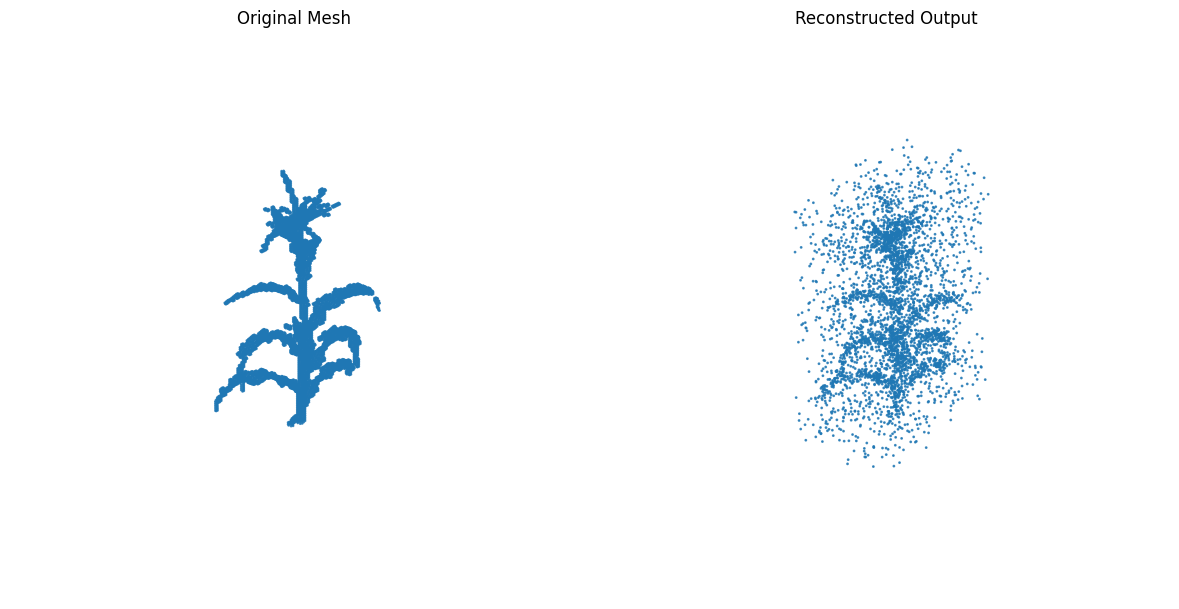

In [24]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(orig_pts[:, 0], orig_pts[:, 1], orig_pts[:, 2],
            s=1, alpha=0.8)
ax1.set_title("Original Mesh")
ax1.set_axis_off()
set_equal_axes(ax1, orig_pts)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(recon_pts[:, 0], recon_pts[:, 1], recon_pts[:, 2],
            s=1, alpha=0.8)
ax2.set_title("Reconstructed Output")
ax2.set_axis_off()
set_equal_axes(ax2, recon_pts)

plt.tight_layout()
plt.show()
